1. Обзор защиты сети

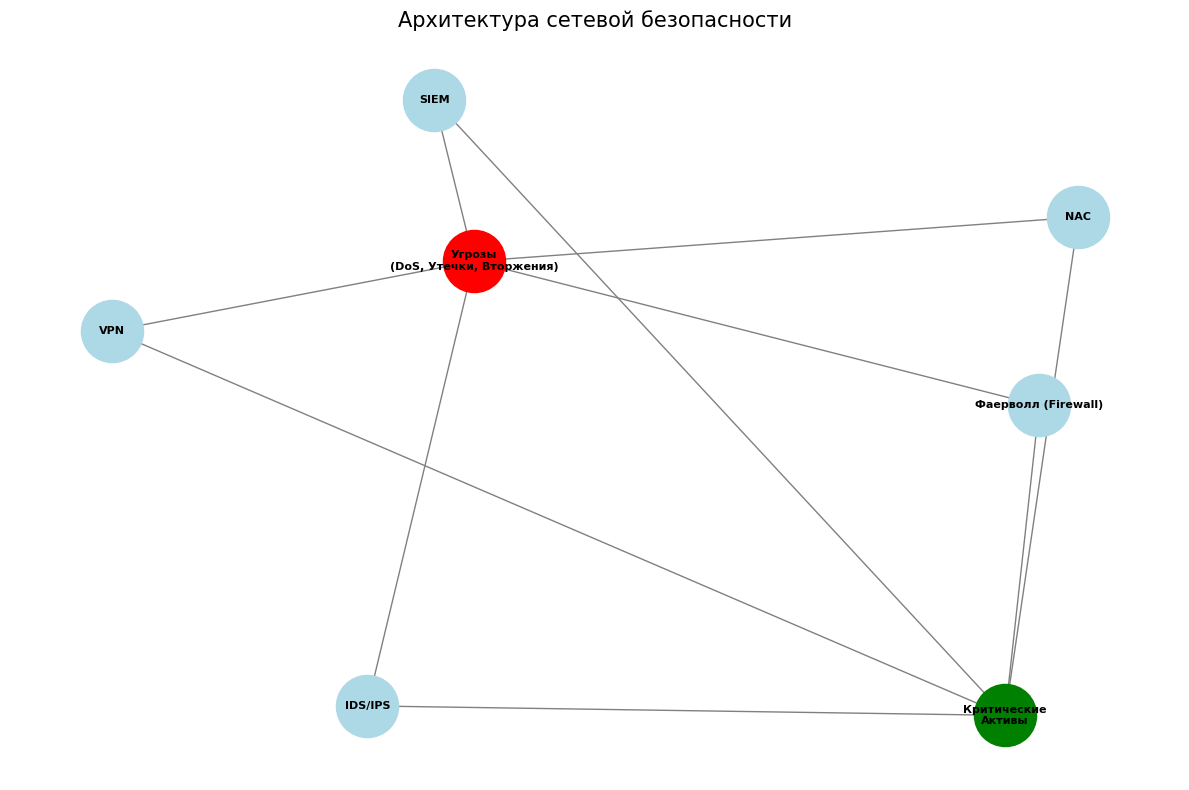

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Создаем граф
G = nx.DiGraph()

# Добавляем узлы (угрозы и средства защиты)
threats = ['Угрозы\n(DoS, Утечки, Вторжения)']
defenses = ['Фаерволл (Firewall)', 'IDS/IPS', 'VPN', 'NAC', 'SIEM']
assets = ['Критические\nАктивы']

all_nodes = threats + defenses + assets
G.add_nodes_from(all_nodes)

# Добавляем связи (угрозы -> средства защиты -> активы)
for defense in defenses:
    G.add_edge(threats[0], defense)  # Угроза направлена на средство защиты
    G.add_edge(defense, assets[0])   # Средство защиты защищает актив

# Настраиваем внешний вид
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(12, 8))

# Рисуем узлы разными цветами
nx.draw_networkx_nodes(G, pos, nodelist=threats, node_color='red', node_size=2000)
nx.draw_networkx_nodes(G, pos, nodelist=defenses, node_color='lightblue', node_size=2000)
nx.draw_networkx_nodes(G, pos, nodelist=assets, node_color='green', node_size=2000)

# Рисуем ребра и подписи
nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True)
nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

plt.title("Архитектура сетевой безопасности", size=15)
plt.axis('off')
plt.tight_layout()
plt.show()

2. Моделирование угроз

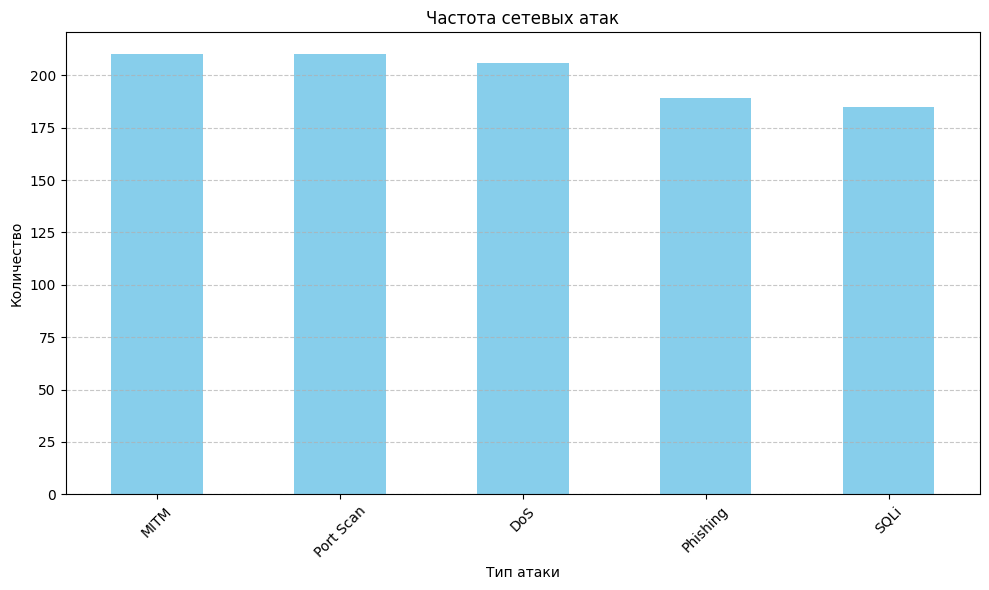

Статистика атак:
Attack_Type
MITM         210
Port Scan    210
DoS          206
Phishing     189
SQLi         185
Name: count, dtype: int64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import random

# Генерация синтетических данных
attacks = ['DoS', 'MITM', 'SQLi', 'Phishing', 'Port Scan']
data = []

for _ in range(1000):
    attack_type = random.choice(attacks)
    duration = random.randint(1, 300)
    src_ip = f"192.168.1.{random.randint(1, 50)}"
    data.append([attack_type, duration, src_ip])

df = pd.DataFrame(data, columns=['Attack_Type', 'Duration', 'Source_IP'])

# Статистика по типам атак
attack_counts = df['Attack_Type'].value_counts()

# Визуализация
plt.figure(figsize=(10, 6))
attack_counts.plot(kind='bar', color='skyblue')
plt.title('Частота сетевых атак')
plt.xlabel('Тип атаки')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Статистика атак:")
print(attack_counts)

3. TCP-клиент

In [ ]:
import socket

def tcp_client():
    # Настройки подключения
    host = 'echo.websocket.events'
    port = 80
    message = 'Hello, Security World!'

    # Создаем TCP-сокет
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as sock:
        try:
            # Подключаемся (блокирующая операция)
            sock.connect((host, port))
            print(f"Подключено к {host}:{port}")

            # Отправляем данные
            sock.sendall(message.encode())
            print(f"Отправлено: {message}")

            # Получаем ответ (блокирующая операция)
            data = sock.recv(1024)
            print(f"Получено: {data.decode()}")

        except Exception as e:
            print(f"Ошибка: {e}")

# Комментарий о блокирующих сокетах:
"""
Блокирующие сокеты могут стать уязвимостью для DoS-атак:
- Сервер блокируется на операции accept/recv
- Атакующий может открыть много соединений без отправки данных
- Ресурсы сервера исчерпываются, легитимные клиенты не обслуживаются
Решение: использование неблокирующих сокетов или пулов потоков
"""

if __name__ == "__main__":
    tcp_client()

Ошибка: [Errno -2] Name or service not known


4. TCP-сервер (многопоточный)

In [ ]:
import socket
import threading
import pandas as pd
from datetime import datetime
import csv
import os

class ThreadedTCPServer:
    def __init__(self, host='localhost', port=9999):
        self.host = host
        self.port = port
        self.log_file = 'network_log.csv'
        self._initialize_log()

    def _initialize_log(self):
        """Создаем файл лога с заголовками"""
        if not os.path.exists(self.log_file):
            with open(self.log_file, 'w', newline='') as f:
                writer = csv.writer(f)
                writer.writerow(['Timestamp', 'Client_IP', 'Client_Port', 'Message'])

    def _log_message(self, client_ip, client_port, message):
        """Логируем сообщение в CSV"""
        timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

        # Запись в CSV
        with open(self.log_file, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([timestamp, client_ip, client_port, message])

        # Вывод в консоль
        print(f"[{timestamp}] {client_ip}:{client_port} -> {message}")

    def handle_client(self, conn, addr):
        """Обработка клиентского соединения"""
        try:
            with conn:
                print(f"Подключен клиент: {addr}")
                while True:
                    data = conn.recv(1024)
                    if not data:
                        break
                    message = data.decode().strip()
                    self._log_message(addr[0], addr[1], message)
                    # Эхо-ответ
                    conn.sendall(f"ECHO: {message}".encode())
        except Exception as e:
            print(f"Ошибка с клиентом {addr}: {e}")

    def start_server(self):
        """Запуск сервера"""
        with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as sock:
            sock.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
            sock.bind((self.host, self.port))
            sock.listen(5)
            print(f"Сервер запущен на {self.host}:{self.port}")

            try:
                while True:
                    conn, addr = sock.accept()
                    # Запускаем отдельный поток для каждого клиента
                    client_thread = threading.Thread(
                        target=self.handle_client,
                        args=(conn, addr)
                    )
                    client_thread.daemon = True
                    client_thread.start()
            except KeyboardInterrupt:
                print("\nСервер остановлен")

            # Показываем статистику
            self.show_statistics()

    def show_statistics(self):
        """Анализ логов с помощью pandas"""
        try:
            df = pd.read_csv(self.log_file)
            print("\n=== СТАТИСТИКА СЕРВЕРА ===")
            print(f"Всего сообщений: {len(df)}")
            print(f"Уникальных клиентов: {df['Client_IP'].nunique()}")
            print("\nТоп клиентов:")
            print(df['Client_IP'].value_counts().head())
        except Exception as e:
            print(f"Ошибка анализа логов: {e}")

if __name__ == "__main__":
    server = ThreadedTCPServer()
    server.start_server()

Сервер запущен на localhost:9999

Сервер остановлен

=== СТАТИСТИКА СЕРВЕРА ===
Всего сообщений: 0
Уникальных клиентов: 0

Топ клиентов:
Series([], Name: count, dtype: int64)


5. UDP-клиент/сервер с потерей пакетов

UDP сервер запущен на порту 9998
Получено от ('127.0.0.1', 35020): Packet 0
Подтверждение: ACK
Пакет от ('127.0.0.1', 35020) потерян!
Таймаут для пакета 1
Получено от ('127.0.0.1', 35020): Packet 2
Подтверждение: ACK
Пакет от ('127.0.0.1', 35020) потерян!
Таймаут для пакета 3
Получено от ('127.0.0.1', 35020): Packet 4
Подтверждение: ACK
Получено от ('127.0.0.1', 35020): Packet 5
Подтверждение: ACK
Пакет от ('127.0.0.1', 35020) потерян!
Таймаут для пакета 6
Получено от ('127.0.0.1', 35020): Packet 7
Подтверждение: ACK
Получено от ('127.0.0.1', 35020): Packet 8
Подтверждение: ACK
Получено от ('127.0.0.1', 35020): Packet 9
Подтверждение: ACK
Получено от ('127.0.0.1', 35020): Packet 10
Подтверждение: ACK
Получено от ('127.0.0.1', 35020): Packet 11
Подтверждение: ACK
Получено от ('127.0.0.1', 35020): Packet 12
Подтверждение: ACK
Получено от ('127.0.0.1', 35020): Packet 13
Подтверждение: ACK
Получено от ('127.0.0.1', 35020): Packet 14
Подтверждение: ACK
Получено от ('127.0.0.1', 35020): Pack

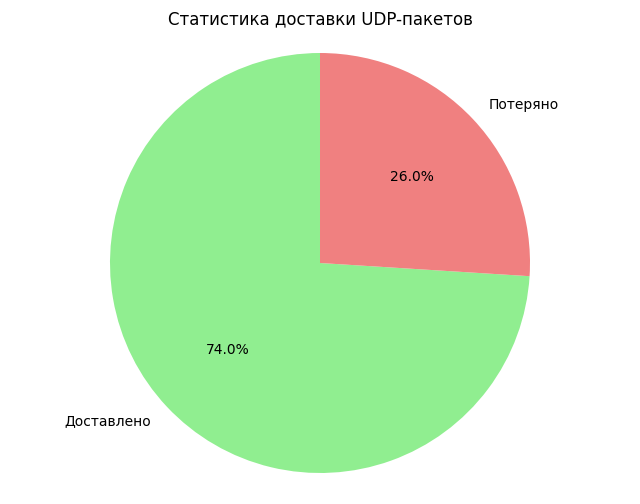


Статистика:
Отправлено пакетов: 100
Получено пакетов: 74
Потеряно пакетов: 26
Процент потерь: 26.00%


In [ ]:
import socket
import threading
import random
import time
import matplotlib.pyplot as plt

class UDPSimulation:
    def __init__(self, loss_probability=0.3):
        self.loss_prob = loss_probability
        self.sent_packets = 0
        self.received_packets = 0

    def udp_server(self):
        """UDP сервер с случайной потерей пакетов"""
        sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
        sock.bind(('localhost', 9998))

        print("UDP сервер запущен на порту 9998")

        while self.sent_packets < 100:  # Ограничим для демонстрации
            data, addr = sock.recvfrom(1024)

            # Имитация потери пакета
            if random.random() < self.loss_prob:
                print(f"Пакет от {addr} потерян!")
                continue

            self.received_packets += 1
            print(f"Получено от {addr}: {data.decode()}")

            # Ответ клиенту
            sock.sendto(b"ACK", addr)

        sock.close()

    def udp_client(self):
        """UDP клиент"""
        time.sleep(1)  # Даем серверу запуститься

        sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)

        for i in range(100):
            message = f"Packet {i}"
            sock.sendto(message.encode(), ('localhost', 9998))
            self.sent_packets += 1

            # Ждем ответ с таймаутом
            sock.settimeout(1.0)
            try:
                data, addr = sock.recvfrom(1024)
                print(f"Подтверждение: {data.decode()}")
            except socket.timeout:
                print(f"Таймаут для пакета {i}")

            time.sleep(0.1)  # Небольшая задержка

        sock.close()

    def visualize_stats(self):
        """Визуализация статистики потерь"""
        lost_packets = self.sent_packets - self.received_packets
        labels = ['Доставлено', 'Потеряно']
        sizes = [self.received_packets, lost_packets]
        colors = ['lightgreen', 'lightcoral']

        plt.figure(figsize=(8, 6))
        plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
        plt.title('Статистика доставки UDP-пакетов')
        plt.axis('equal')
        plt.show()

        loss_percentage = (lost_packets / self.sent_packets) * 100
        print(f"\nСтатистика:")
        print(f"Отправлено пакетов: {self.sent_packets}")
        print(f"Получено пакетов: {self.received_packets}")
        print(f"Потеряно пакетов: {lost_packets}")
        print(f"Процент потерь: {loss_percentage:.2f}%")

def run_udp_simulation():
    sim = UDPSimulation(loss_probability=0.3)

    # Запускаем сервер в отдельном потоке
    server_thread = threading.Thread(target=sim.udp_server)
    server_thread.daemon = True
    server_thread.start()

    # Запускаем клиента
    sim.udp_client()

    # Визуализация
    sim.visualize_stats()

if __name__ == "__main__":
    run_udp_simulation()

6. Мини-файервол

In [ ]:
from scapy.all import *
import time

class SimpleFirewall:
    def __init__(self):
        self.blocked_ips = ['10.0.0.100', '192.168.1.200']  # Заблокированные IP
        self.packet_count = 0
        self.blocked_count = 0

    def packet_handler(self, packet):
        """Обработчик пакетов"""
        self.packet_count += 1

        # Проверяем IP-адреса
        if IP in packet:
            src_ip = packet[IP].src
            dst_ip = packet[IP].dst

            # Блокируем пакеты от/к заблокированным IP
            if src_ip in self.blocked_ips or dst_ip in self.blocked_ips:
                self.blocked_count += 1
                print(f"🚫 БЛОКИРОВКА: {src_ip} -> {dst_ip} | Протокол: {packet[IP].proto}")
                return  # Отбрасываем пакет

            # Разрешаем нормальный трафик
            print(f"✅ РАЗРЕШЕНО: {src_ip} -> {dst_ip} | Протокол: {packet[IP].proto}")

    def start_firewall(self, duration=30):
        """Запуск фаервола на указанное время"""
        print(f"🚀 Запуск мини-фаервола...")
        print(f"Заблокированные IP: {self.blocked_ips}")
        print(f"Время работы: {duration} секунд")
        print("-" * 50)

        # Начинаем перехват пакетов
        sniff(prn=self.packet_handler, timeout=duration)

        # Статистика
        print("\n" + "="*50)
        print("СТАТИСТИКА ФАЕРВОЛА:")
        print(f"Всего пакетов: {self.packet_count}")
        print(f"Заблокировано: {self.blocked_count}")
        print(f"Пропущено: {self.packet_count - self.blocked_count}")

# Демонстрация (требуются права администратора)
if __name__ == "__main__":
    fw = SimpleFirewall()

    # Для безопасности ограничим время работы
    try:
        fw.start_firewall(duration=30)
    except PermissionError:
        print("❌ Требуются права администратора для захвата пакетов!")
        print("Запустите скрипт от имени администратора/root")

ModuleNotFoundError: No module named 'scapy'

7. ARP-спуфинг (синтетический пример)

In [ ]:
from scapy.all import *
import pandas as pd

def create_arp_spoofing_demo():
    """Создание демонстрационного pcap с ARP-спуфингом"""

    # Нормальные ARP-запросы
    normal_packets = []

    # Легитимные устройства
    legitimate_devices = {
        '192.168.1.1': '00:11:22:33:44:55',  # Роутер
        '192.168.1.10': 'aa:bb:cc:dd:ee:ff', # Компьютер 1
        '192.168.1.20': '12:34:56:78:90:ab'  # Компьютер 2
    }

    # Атакующее устройство
    attacker_mac = 'ff:ff:ff:ff:ff:ff'

    # Генерируем нормальные ARP-пакеты
    for ip, mac in legitimate_devices.items():
        # ARP-запрос
        arp_request = Ether(src=mac)/ARP(pdst="192.168.1.255", psrc=ip, hwsrc=mac)
        normal_packets.append(arp_request)

        # ARP-ответ
        for target_ip, target_mac in legitimate_devices.items():
            if target_ip != ip:
                arp_reply = Ether(src=mac)/ARP(
                    op=2,  # Ответ
                    pdst=target_ip,
                    psrc=ip,
                    hwsrc=mac,
                    hwdst=target_mac
                )
                normal_packets.append(arp_reply)

    # Генерируем ARP-спуфинг пакеты
    spoofed_packets = []
    for target_ip, target_mac in legitimate_devices.items():
        # Атакующий выдает себя за роутер
        spoofed_arp = Ether(src=attacker_mac)/ARP(
            op=2,
            pdst=target_ip,
            psrc='192.168.1.1',  # Подменяем IP роутера
            hwsrc=attacker_mac,  # Но используем MAC атакующего
            hwdst=target_mac
        )
        spoofed_packets.append(spoofed_arp)

    # Сохраняем в pcap файл
    wrpcap('arp_demo.pcap', normal_packets + spoofed_packets)
    return legitimate_devices, attacker_mac

def analyze_arp_traffic():
    """Анализ ARP-трафика"""
    try:
        packets = rdpcap('arp_demo.pcap')
    except:
        print("Сначала создайте демонстрационный файл")
        return

    arp_table = {}
    suspicious_entries = []

    for packet in packets:
        if packet.haslayer(ARP):
            arp = packet[ARP]
            src_ip = arp.psrc
            src_mac = arp.hwsrc

            # Проверяем изменения в ARP-таблице
            if src_ip in arp_table:
                if arp_table[src_ip] != src_mac:
                    suspicious_entries.append({
                        'ip': src_ip,
                        'old_mac': arp_table[src_ip],
                        'new_mac': src_mac,
                        'type': 'ARP Spoofing'
                    })

            arp_table[src_ip] = src_mac

    # Выводим результаты
    print("=== ARP ТАБЛИЦА ===")
    for ip, mac in arp_table.items():
        print(f"IP: {ip:15} -> MAC: {mac}")

    print("\n=== ПОДОЗРИТЕЛЬНЫЕ ИЗМЕНЕНИЯ ===")
    if suspicious_entries:
        df = pd.DataFrame(suspicious_entries)
        print(df)
    else:
        print("Подозрительных изменений не обнаружено")

if __name__ == "__main__":
    # Создаем демонстрационный файл
    legitimate, attacker = create_arp_spoofing_demo()

    print("Легитимные устройства:")
    for ip, mac in legitimate.items():
        print(f"  {ip} -> {mac}")

    print(f"\nMAC атакующего: {attacker}")
    print("\nАнализ трафика...")

    # Анализируем
    analyze_arp_traffic()

ModuleNotFoundError: No module named 'scapy'

8. Sniffer (анализатор пакетов)

In [ ]:
from scapy.all import *
import matplotlib.pyplot as plt
import pandas as pd

class PacketSniffer:
    def __init__(self, count=10):
        self.packet_count = count
        self.protocols = {}
        self.ports = {}

    def analyze_packet(self, packet):
        """Анализ отдельного пакета"""
        protocol = "Unknown"
        src_port = dst_port = None

        # Определяем протокол
        if packet.haslayer(IP):
            proto_num = packet[IP].proto
            if proto_num == 6:
                protocol = "TCP"
            elif proto_num == 17:
                protocol = "UDP"
            elif proto_num == 1:
                protocol = "ICMP"
            else:
                protocol = f"IP-{proto_num}"

            # Анализ портов для TCP/UDP
            if packet.haslayer(TCP):
                src_port = packet[TCP].sport
                dst_port = packet[TCP].dport
            elif packet.haslayer(UDP):
                src_port = packet[UDP].sport
                dst_port = packet[UDP].dport

        # Собираем статистику
        self.protocols[protocol] = self.protocols.get(protocol, 0) + 1

        if src_port:
            self.ports[src_port] = self.ports.get(src_port, 0) + 1
        if dst_port:
            self.ports[dst_port] = self.ports.get(dst_port, 0) + 1

        # Выводим информацию о пакете
        info = f"Протокол: {protocol:8}"
        if src_port and dst_port:
            info += f" | Порты: {src_port}->{dst_port}"
        if packet.haslayer(IP):
            info += f" | {packet[IP].src} -> {packet[IP].dst}"

        print(info)

    def start_sniffing(self):
        """Запуск сниффера"""
        print(f"🎯 Захватываем {self.packet_count} пакетов...")
        print("-" * 60)

        # Захват пакетов
        sniff(prn=self.analyze_packet, count=self.packet_count)

        # Визуализация
        self.visualize_results()

    def visualize_results(self):
        """Визуализация статистики"""
        # Гистограмма протоколов
        if self.protocols:
            plt.figure(figsize=(12, 5))

            plt.subplot(1, 2, 1)
            protocols_df = pd.DataFrame({
                'Protocol': list(self.protocols.keys()),
                'Count': list(self.protocols.values())
            })
            plt.bar(protocols_df['Protocol'], protocols_df['Count'], color='skyblue')
            plt.title('Распределение протоколов')
            plt.xlabel('Протокол')
            plt.ylabel('Количество пакетов')
            plt.xticks(rotation=45)

            # Топ портов
            plt.subplot(1, 2, 2)
            if self.ports:
                ports_df = pd.DataFrame({
                    'Port': list(self.ports.keys()),
                    'Count': list(self.ports.values())
                }).sort_values('Count', ascending=False).head(10)

                plt.bar(ports_df['Port'].astype(str), ports_df['Count'], color='lightcoral')
                plt.title('Топ-10 портов')
                plt.xlabel('Порт')
                plt.ylabel('Количество обращений')
                plt.xticks(rotation=45)

            plt.tight_layout()
            plt.show()

        # Вывод статистики
        print("\n" + "="*60)
        print("СТАТИСТИКА ЗАХВАТА:")
        print(f"Всего пакетов: {self.packet_count}")
        print(f"Обнаружено протоколов: {len(self.protocols)}")
        print(f"Уникальных портов: {len(self.ports)}")

# Демонстрация
if __name__ == "__main__":
    sniffer = PacketSniffer(count=10)
    try:
        sniffer.start_sniffing()
    except PermissionError:
        print("❌ Требуются права администратора!")

ModuleNotFoundError: No module named 'scapy'

9. Сетевая аномалия (SYN-flood)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scapy.all import *
import random

class TrafficAnalyzer:
    def __init__(self):
        self.normal_traffic = []
        self.anomalous_traffic = []

    def generate_normal_traffic(self, count=1000):
        """Генерация нормального трафика"""
        print("Генерация нормального трафика...")

        for _ in range(count):
            # Нормальные параметры
            packet_size = random.randint(40, 1500)  # Размер пакета
            packets_per_second = random.randint(1, 10)  # Пакетов в секунду
            connections_per_minute = random.randint(1, 50)  # Соединений в минуту

            self.normal_traffic.append([
                packet_size, packets_per_second, connections_per_minute
            ])

    def generate_syn_flood(self, count=1000):
        """Генерация SYN-flood атаки"""
        print("Генерация SYN-flood трафика...")

        for _ in range(count):
            # Характеристики SYN-flood
            packet_size = random.randint(40, 100)  # Маленькие SYN-пакеты
            packets_per_second = random.randint(100, 1000)  # Очень высокая частота
            connections_per_minute = random.randint(1000, 10000)  # Огромное число соединений

            self.anomalous_traffic.append([
                packet_size, packets_per_second, connections_per_minute
            ])

    def analyze_traffic(self):
        """Сравнительный анализ трафика"""
        normal_df = pd.DataFrame(self.normal_traffic,
                               columns=['Packet_Size', 'Packets_Per_Second', 'Connections_Per_Minute'])
        anomalous_df = pd.DataFrame(self.anomalous_traffic,
                                  columns=['Packet_Size', 'Packets_Per_Second', 'Connections_Per_Minute'])

        # Статистика
        print("\n=== СТАТИСТИКА НОРМАЛЬНОГО ТРАФИКА ===")
        print(normal_df.describe())

        print("\n=== СТАТИСТИКА SYN-FLOOD ТРАФИКА ===")
        print(anomalous_df.describe())

        return normal_df, anomalous_df

    def visualize_comparison(self, normal_df, anomalous_df):
        """Визуализация сравнения"""
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        metrics = ['Packet_Size', 'Packets_Per_Second', 'Connections_Per_Minute']
        titles = ['Размер пакета (байты)', 'Пакетов в секунду', 'Соединений в минуту']

        for i, (metric, title) in enumerate(zip(metrics, titles)):
            # Подготовка данных для boxplot
            data = [normal_df[metric], anomalous_df[metric]]

            axes[i].boxplot(data, labels=['Нормальный', 'SYN-Flood'])
            axes[i].set_title(title)
            axes[i].set_ylabel('Значение')
            axes[i].grid(True, linestyle='--', alpha=0.7)

        plt.suptitle('Сравнение нормального трафика и SYN-Flood атаки', fontsize=14)
        plt.tight_layout()
        plt.show()

        # Дополнительная визуализация - гистограмма частоты пакетов
        plt.figure(figsize=(10, 6))

        plt.hist(normal_df['Packets_Per_Second'], bins=30, alpha=0.7,
                label='Нормальный', color='blue')
        plt.hist(anomalous_df['Packets_Per_Second'], bins=30, alpha=0.7,
                label='SYN-Flood', color='red')

        plt.xlabel('Пакетов в секунду')
        plt.ylabel('Частота')
        plt.title('Распределение частоты пакетов')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

def demonstrate_anomaly():
    """Демонстрация обнаружения аномалий"""
    analyzer = TrafficAnalyzer()

    # Генерируем данные
    analyzer.generate_normal_traffic(1000)
    analyzer.generate_syn_flood(1000)

    # Анализируем
    normal_df, anomalous_df = analyzer.analyze_traffic()

    # Визуализируем
    analyzer.visualize_comparison(normal_df, anomalous_df)

    # Простое правило обнаружения
    print("\n=== ПРАВИЛА ОБНАРУЖЕНИЯ SYN-FLOOD ===")
    normal_pps_mean = normal_df['Packets_Per_Second'].mean()
    anomalous_pps_mean = anomalous_df['Packets_Per_Second'].mean()

    print(f"Средняя частота пакетов (нормальная): {normal_pps_mean:.2f}")
    print(f"Средняя частота пакетов (SYN-flood): {anomalous_pps_mean:.2f}")
    print(f"Отношение: {anomalous_pps_mean/normal_pps_mean:.1f}x")

    # Правило обнаружения
    threshold = normal_pps_mean * 10  # Порог в 10 раз выше нормы
    print(f"Порог обнаружения: {threshold:.2f} пакетов/секунду")

if __name__ == "__main__":
    demonstrate_anomaly()

ModuleNotFoundError: No module named 'scapy'

10. Логирование событий в SQLite

In [ ]:
import sqlite3
import pandas as pd
from datetime import datetime
import random

class NetworkLogger:
    def __init__(self, db_name='network_events.db'):
        self.db_name = db_name
        self._init_database()

    def _init_database(self):
        """Инициализация базы данных"""
        conn = sqlite3.connect(self.db_name)
        cursor = conn.cursor()

        cursor.execute('''
            CREATE TABLE IF NOT EXISTS network_events (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                timestamp TEXT NOT NULL,
                source_ip TEXT NOT NULL,
                destination_ip TEXT,
                protocol TEXT,
                port INTEGER,
                event_type TEXT,
                severity TEXT,
                description TEXT
            )
        ''')

        conn.commit()
        conn.close()
        print(f"База данных {self.db_name} инициализирована")

    def log_event(self, source_ip, destination_ip=None, protocol=None,
                 port=None, event_type='Network', severity='INFO', description=''):
        """Логирование события"""
        timestamp = datetime.now().isoformat()

        conn = sqlite3.connect(self.db_name)
        cursor = conn.cursor()

        cursor.execute('''
            INSERT INTO network_events
            (timestamp, source_ip, destination_ip, protocol, port, event_type, severity, description)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?)
        ''', (timestamp, source_ip, destination_ip, protocol, port, event_type, severity, description))

        conn.commit()
        conn.close()

        print(f"📝 Записано событие: {source_ip} -> {event_type} ({severity})")

    def search_by_ip(self, ip_address):
        """Поиск событий по IP-адресу"""
        conn = sqlite3.connect(self.db_name)

        query = '''
            SELECT * FROM network_events
            WHERE source_ip = ? OR destination_ip = ?
            ORDER BY timestamp DESC
        '''

        df = pd.read_sql_query(query, conn, params=(ip_address, ip_address))
        conn.close()

        return df

    def generate_sample_data(self, num_events=100):
        """Генерация тестовых данных"""
        protocols = ['TCP', 'UDP', 'ICMP', 'HTTP', 'HTTPS']
        event_types = ['Connection', 'Authentication', 'Scan', 'Transfer', 'Error']
        severities = ['INFO', 'WARNING', 'ERROR', 'CRITICAL']

        for i in range(num_events):
            source_ip = f"192.168.1.{random.randint(1, 254)}"
            dest_ip = f"10.0.0.{random.randint(1, 254)}"
            protocol = random.choice(protocols)
            port = random.randint(1, 65535) if protocol in ['TCP', 'UDP'] else None
            event_type = random.choice(event_types)
            severity = random.choice(severities)
            description = f"Sample event {i+1}"

            self.log_event(source_ip, dest_ip, protocol, port, event_type, severity, description)

    def get_statistics(self):
        """Получение статистики по логам"""
        conn = sqlite3.connect(self.db_name)

        # Общая статистика
        stats_query = '''
            SELECT
                COUNT(*) as total_events,
                COUNT(DISTINCT source_ip) as unique_ips,
                MIN(timestamp) as first_event,
                MAX(timestamp) as last_event
            FROM network_events
        '''

        stats_df = pd.read_sql_query(stats_query, conn)

        # Статистика по протоколам
        protocol_stats = pd.read_sql_query(
            'SELECT protocol, COUNT(*) as count FROM network_events GROUP BY protocol', conn
        )

        # Статистика по severity
        severity_stats = pd.read_sql_query(
            'SELECT severity, COUNT(*) as count FROM network_events GROUP BY severity', conn
        )

        conn.close()

        return stats_df, protocol_stats, severity_stats

def demonstrate_logging():
    """Демонстрация работы системы логирования"""
    logger = NetworkLogger()

    # Генерируем тестовые данные
    print("Генерация тестовых данных...")
    logger.generate_sample_data(50)

    # Поиск по конкретному IP
    print("\n🔍 Поиск событий для IP 192.168.1.100:")
    results = logger.search_by_ip('192.168.1.100')
    if not results.empty:
        print(results.head())
    else:
        print("Событий не найдено")

    # Статистика
    print("\n📊 Статистика логов:")
    stats_df, protocol_stats, severity_stats = logger.get_statistics()

    print("Общая статистика:")
    print(stats_df)

    print("\nСтатистика по протоколам:")
    print(protocol_stats)

    print("\nСтатистика по важности:")
    print(severity_stats)

    # Пример добавления реального события
    logger.log_event(
        source_ip='192.168.1.50',
        destination_ip='8.8.8.8',
        protocol='DNS',
        port=53,
        event_type='Query',
        severity='INFO',
        description='DNS запрос к Google DNS'
    )

if __name__ == "__main__":
    demonstrate_logging()

База данных network_events.db инициализирована
Генерация тестовых данных...
📝 Записано событие: 192.168.1.5 -> Error (CRITICAL)
📝 Записано событие: 192.168.1.49 -> Authentication (ERROR)
📝 Записано событие: 192.168.1.14 -> Error (CRITICAL)
📝 Записано событие: 192.168.1.173 -> Error (INFO)
📝 Записано событие: 192.168.1.150 -> Error (INFO)
📝 Записано событие: 192.168.1.149 -> Transfer (INFO)
📝 Записано событие: 192.168.1.251 -> Transfer (ERROR)
📝 Записано событие: 192.168.1.73 -> Transfer (ERROR)
📝 Записано событие: 192.168.1.87 -> Transfer (ERROR)
📝 Записано событие: 192.168.1.209 -> Scan (WARNING)
📝 Записано событие: 192.168.1.125 -> Connection (WARNING)
📝 Записано событие: 192.168.1.102 -> Authentication (CRITICAL)
📝 Записано событие: 192.168.1.210 -> Transfer (CRITICAL)
📝 Записано событие: 192.168.1.122 -> Scan (WARNING)
📝 Записано событие: 192.168.1.138 -> Connection (ERROR)
📝 Записано событие: 192.168.1.11 -> Connection (WARNING)
📝 Записано событие: 192.168.1.84 -> Transfer (WARNIN

11. Введение в IDS с ROC-кривой

Генерация сетевого трафика...

=== РЕЗУЛЬТАТЫ ОБНАРУЖЕНИЯ ===
Всего событий: 2000
Аномальных событий: 201
Обнаружено подозрительных: 284

=== СРАБАТЫВАНИЯ ПРАВИЛ ===
High Packet Rate: 201 срабатываний
Common Port Scan: 203 срабатываний
Small Packets: 88 срабатываний


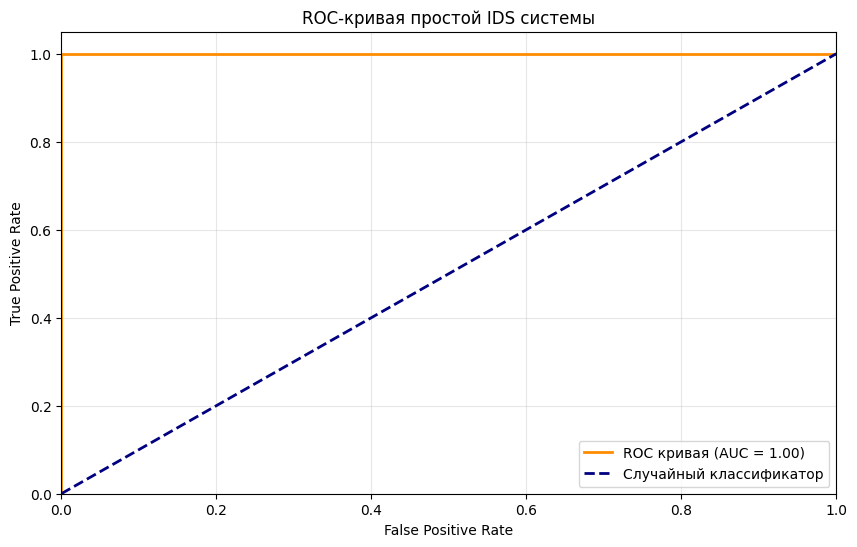


AUC Score: 1.000
Оптимальный порог: 0.67
При этом пороге: TPR=1.00, FPR=0.00

=== ПРИМЕРЫ ПОДОЗРИТЕЛЬНЫХ СОБЫТИЙ ===
IP: 192.168.1.45, Score: 2, Triggers: ['High Packet Rate', 'Common Port Scan']
IP: 192.168.1.35, Score: 2, Triggers: ['High Packet Rate', 'Common Port Scan']
IP: 192.168.1.3, Score: 3, Triggers: ['High Packet Rate', 'Common Port Scan', 'Small Packets']
IP: 192.168.1.5, Score: 2, Triggers: ['High Packet Rate', 'Common Port Scan']
IP: 192.168.1.30, Score: 3, Triggers: ['High Packet Rate', 'Common Port Scan', 'Small Packets']


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

class SimpleIDS:
    def __init__(self):
        self.rules = []

    def add_rule(self, name, condition_fn):
        """Добавление правила обнаружения"""
        self.rules.append({'name': name, 'condition': condition_fn})

    def generate_traffic_data(self, n_samples=1000):
        """Генерация синтетических данных сетевого трафика"""
        np.random.seed(42)

        data = []
        for i in range(n_samples):
            # Нормальные параметры
            src_ip = f"192.168.1.{np.random.randint(1, 50)}"
            dst_port = np.random.randint(1, 10000)
            packet_size = np.random.randint(40, 1500)
            packets_per_second = np.random.poisson(10)  # Нормальная частота

            # 10% трафика - аномальный (метка 1)
            is_anomalous = np.random.random() < 0.1

            if is_anomalous:
                # Аномальные характеристики
                packets_per_second = np.random.poisson(100)  # Высокая частота
                dst_port = np.random.choice([21, 22, 23, 80, 443, 3389])  # Популярные порты

            data.append({
                'src_ip': src_ip,
                'dst_port': dst_port,
                'packet_size': packet_size,
                'packets_per_second': packets_per_second,
                'is_anomalous': int(is_anomalous)
            })

        return pd.DataFrame(data)

    def setup_rules(self):
        """Настройка простых правил обнаружения"""
        # Правило 1: Высокая частота пакетов
        self.add_rule('High Packet Rate',
                     lambda row: row['packets_per_second'] > 50)

        # Правило 2: Популярные порты
        common_ports = [21, 22, 23, 80, 443, 3389]
        self.add_rule('Common Port Scan',
                     lambda row: row['dst_port'] in common_ports)

        # Правило 3: Маленькие пакеты (возможно сканирование)
        self.add_rule('Small Packets',
                     lambda row: row['packet_size'] < 100)

    def detect_anomalies(self, df):
        """Обнаружение аномалий с помощью правил"""
        scores = []

        for _, row in df.iterrows():
            score = 0
            triggers = []

            for rule in self.rules:
                if rule['condition'](row):
                    score += 1
                    triggers.append(rule['name'])

            scores.append({
                'ip': row['src_ip'],
                'score': score,
                'triggers': triggers,
                'is_anomalous': row['is_anomalous']
            })

        return pd.DataFrame(scores)

    def plot_roc_curve(self, y_true, y_scores):
        """Построение ROC-кривой"""
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(10, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                label=f'ROC кривая (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
                label='Случайный классификатор')

        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC-кривая простой IDS системы')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.show()

        return fpr, tpr, thresholds, roc_auc

def demonstrate_ids():
    """Демонстрация работы простой IDS"""
    ids = SimpleIDS()

    # Генерируем данные
    print("Генерация сетевого трафика...")
    df = ids.generate_traffic_data(2000)

    # Настраиваем правила
    ids.setup_rules()

    # Обнаруживаем аномалии
    results = ids.detect_anomalies(df)

    # Анализируем результаты
    print("\n=== РЕЗУЛЬТАТЫ ОБНАРУЖЕНИЯ ===")
    print(f"Всего событий: {len(results)}")
    print(f"Аномальных событий: {results['is_anomalous'].sum()}")
    print(f"Обнаружено подозрительных: {(results['score'] > 0).sum()}")

    # Статистика по правилам
    print("\n=== СРАБАТЫВАНИЯ ПРАВИЛ ===")
    for rule in ids.rules:
        count = results[results['triggers'].apply(
            lambda x: rule['name'] in x if x else False
        )].shape[0]
        print(f"{rule['name']}: {count} срабатываний")

    # ROC-кривая
    y_true = results['is_anomalous']
    y_scores = results['score'] / len(ids.rules)  # Нормализуем scores

    fpr, tpr, thresholds, auc_score = ids.plot_roc_curve(y_true, y_scores)

    print(f"\nAUC Score: {auc_score:.3f}")

    # Находим оптимальный порог (ближайший к (0,1))
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    print(f"Оптимальный порог: {optimal_threshold:.2f}")
    print(f"При этом пороге: TPR={tpr[optimal_idx]:.2f}, FPR={fpr[optimal_idx]:.2f}")

    # Пример подозрительных событий
    suspicious = results[results['score'] >= 2].head(5)
    if not suspicious.empty:
        print("\n=== ПРИМЕРЫ ПОДОЗРИТЕЛЬНЫХ СОБЫТИЙ ===")
        for _, event in suspicious.iterrows():
            print(f"IP: {event['ip']}, Score: {event['score']}, Triggers: {event['triggers']}")

if __name__ == "__main__":
    demonstrate_ids()

12. Сканирование портов (многопоточный)

In [ ]:
import socket
import threading
import time
from concurrent.futures import ThreadPoolExecutor
import ipaddress

class PortScanner:
    def __init__(self, max_threads=100, timeout=1.0):
        self.max_threads = max_threads
        self.timeout = timeout
        self.open_ports = []
        self.scan_results = {}

    def scan_port(self, target, port):
        """Сканирование одного порта"""
        try:
            with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as sock:
                sock.settimeout(self.timeout)
                result = sock.connect_ex((target, port))

                if result == 0:
                    service_name = self.get_service_name(port)
                    return port, 'open', service_name
                else:
                    return port, 'closed', None

        except Exception as e:
            return port, 'error', str(e)

    def get_service_name(self, port):
        """Получение имени службы по порту"""
        try:
            return socket.getservbyport(port, 'tcp')
        except:
            return 'unknown'

    def scan_target(self, target, ports_range=(1, 1000)):
        """Сканирование диапазона портов на целевом хосте"""
        start_port, end_port = ports_range
        ports_to_scan = range(start_port, end_port + 1)

        print(f"🔍 Сканирование {target} (порты {start_port}-{end_port})...")
        start_time = time.time()

        with ThreadPoolExecutor(max_workers=self.max_threads) as executor:
            # Запускаем сканирование портов в потоках
            futures = [
                executor.submit(self.scan_port, target, port)
                for port in ports_to_scan
            ]

            # Собираем результаты
            for future in futures:
                port, status, service = future.result()

                if status == 'open':
                    self.open_ports.append(port)
                    self.scan_results[port] = {
                        'status': status,
                        'service': service,
                        'target': target
                    }
                    print(f"✅ Порт {port}/tcp открыт - {service}")

        elapsed_time = time.time() - start_time
        self.print_scan_summary(target, elapsed_time)

    def print_scan_summary(self, target, elapsed_time):
        """Вывод сводки сканирования"""
        print(f"\n{'='*50}")
        print(f"РЕЗУЛЬТАТЫ СКАНИРОВАНИЯ {target}")
        print(f"{'='*50}")
        print(f"Время сканирования: {elapsed_time:.2f} секунд")
        print(f"Открытых портов: {len(self.open_ports)}")
        print(f"Сканированных портов: {1000}")  # По умолчанию 1-1000

        if self.open_ports:
            print("\n📋 Открытые порты:")
            for port in sorted(self.open_ports):
                service = self.scan_results[port]['service']
                print(f"  Порт {port}/tcp - {service}")

        # Анализ безопасности
        self.security_analysis()

    def security_analysis(self):
        """Простой анализ безопасности"""
        dangerous_ports = {
            21: 'FTP - возможна передача паролей в открытом виде',
            22: 'SSH - убедитесь в надежности паролей',
            23: 'Telnet - небезопасный протокол',
            80: 'HTTP - трафик не шифруется',
            443: 'HTTPS - шифрование включено',
            3389: 'RDP - удаленный рабочий стол'
        }

        print("\n⚠️  АНАЛИЗ БЕЗОПАСНОСТИ:")
        for port in self.open_ports:
            if port in dangerous_ports:
                print(f"  Порт {port}: {dangerous_ports[port]}")

    def scan_network(self, network_cidr, ports_range=(1, 100)):
        """Сканирование сети"""
        try:
            network = ipaddress.ip_network(network_cidr, strict=False)
            print(f"🌐 Сканирование сети: {network_cidr}")

            for ip in network.hosts():
                if str(ip).endswith('.0') or str(ip).endswith('.255'):
                    continue  # Пропускаем сетевой и широковещательный адреса

                self.scan_target(str(ip), ports_range)
                self.open_ports = []  # Сбрасываем для следующего хоста

        except ValueError as e:
            print(f"❌ Ошибка в формате сети: {e}")

def demonstrate_port_scanning():
    """Демонстрация сканирования портов"""
    scanner = PortScanner(max_threads=50, timeout=0.5)

    # Варианты сканирования:

    # 1. Локальный хост (безопасно)
    print("1. Сканирование localhost:")
    scanner.scan_target('127.0.0.1', ports_range=(1, 200))

    # 2. Пример сканирования (закомментировано для безопасности)
    # scanner.scan_target('google.com', ports_range=(79, 85))

    # 3. Сканирование маленькой сети (только первые 10 портов)
    # print("\n2. Сканирование маленькой сети:")
    # scanner.scan_network('192.168.1.0/24', ports_range=(1, 10))

# Важное предупреждение
print("""
⚠️  ВНИМАНИЕ:
- Сканирование портов без разрешения может быть незаконным
- Используйте только на своих системах или с явного разрешения
- Некоторые провайдеры могут блокировать сканирование портов
""")

if __name__ == "__main__":
    demonstrate_port_scanning()


⚠️  ВНИМАНИЕ: 
- Сканирование портов без разрешения может быть незаконным
- Используйте только на своих системах или с явного разрешения
- Некоторые провайдеры могут блокировать сканирование портов

1. Сканирование localhost:
🔍 Сканирование 127.0.0.1 (порты 1-200)...

РЕЗУЛЬТАТЫ СКАНИРОВАНИЯ 127.0.0.1
Время сканирования: 0.04 секунд
Открытых портов: 0
Сканированных портов: 1000

⚠️  АНАЛИЗ БЕЗОПАСНОСТИ:


13. SSH-туннелирование (Paramiko)

In [ ]:
import paramiko
import getpass
from io import StringIO

class SSHTunnelDemo:
    def __init__(self):
        self.client = None

    def connect_with_password(self, hostname, username, password, port=22):
        """Подключение с использованием пароля"""
        try:
            self.client = paramiko.SSHClient()
            self.client.set_missing_host_key_policy(paramiko.AutoAddPolicy())

            print(f"🔐 Подключение к {username}@{hostname}:{port}...")
            self.client.connect(hostname, port=port, username=username, password=password)

            print("✅ Подключение установлено!")
            return True

        except paramiko.AuthenticationException:
            print("❌ Ошибка аутентификации: неверный пароль или логин")
            return False
        except paramiko.SSHException as e:
            print(f"❌ Ошибка SSH: {e}")
            return False
        except Exception as e:
            print(f"❌ Ошибка подключения: {e}")
            return False

    def connect_with_key(self, hostname, username, key_path, port=22):
        """Подключение с использованием SSH-ключа"""
        try:
            self.client = paramiko.SSHClient()
            self.client.set_missing_host_key_policy(paramiko.AutoAddPolicy())

            # Загрузка приватного ключа
            key = paramiko.RSAKey.from_private_key_file(key_path)

            print(f"🔐 Подключение с ключом к {username}@{hostname}:{port}...")
            self.client.connect(hostname, port=port, username=username, pkey=key)

            print("✅ Подключение установлено!")
            return True

        except Exception as e:
            print(f"❌ Ошибка подключения: {e}")
            return False

    def execute_command(self, command):
        """Выполнение команды на удаленном сервере"""
        if not self.client:
            print("❌ Сначала установите подключение")
            return None

        try:
            print(f"🚀 Выполнение команды: {command}")
            stdin, stdout, stderr = self.client.exec_command(command)

            # Читаем вывод
            exit_status = stdout.channel.recv_exit_status()
            output = stdout.read().decode()
            errors = stderr.read().decode()

            print(f"📊 Код завершения: {exit_status}")

            if output:
                print("📋 Вывод команды:")
                print(output)

            if errors:
                print("❌ Ошибки:")
                print(errors)

            return output, errors, exit_status

        except Exception as e:
            print(f"❌ Ошибка выполнения команды: {e}")
            return None

    def create_tunnel(self, local_port, remote_host, remote_port):
        """Создание SSH-туннеля"""
        try:
            if not self.client:
                print("❌ Сначала установите подключение")
                return False

            # Получаем транспорт
            transport = self.client.get_transport()

            # Создаем туннель
            transport.request_port_forward('', local_port)

            print(f"🔗 Туннель создан: localhost:{local_port} -> {remote_host}:{remote_port}")
            print("Туннель шифрует весь трафик между клиентом и сервером")
            return True

        except Exception as e:
            print(f"❌ Ошибка создания туннеля: {e}")
            return False

    def disconnect(self):
        """Закрытие подключения"""
        if self.client:
            self.client.close()
            print("🔒 Подключение закрыто")

def demonstrate_ssh():
    """Демонстрация SSH возможностей"""
    ssh = SSHTunnelDemo()

    # Пример подключения (закомментировано для безопасности)
    """
    # Способ 1: С паролем
    host = input("Введите хост: ")
    user = input("Введите пользователя: ")
    password = getpass.getpass("Введите пароль: ")

    if ssh.connect_with_password(host, user, password):
        # Выполняем команды
        ssh.execute_command('uname -a')
        ssh.execute_command('df -h')
        ssh.execute_command('netstat -tuln | head -10')

        # Создаем туннель (пример)
        # ssh.create_tunnel(8080, 'internal-server', 80)

    # Способ 2: С ключом
    # key_path = input("Введите путь к ключу: ")
    # ssh.connect_with_key(host, user, key_path)
    """

    # Теоретическая демонстрация
    print("""
📚 Теоретическая демонстрация SSH туннелирования:

1. **Шифрование канала**: SSH шифрует весь трафик между клиентом и сервером
2. **Аутентификация**: Проверка подлинности с помощью паролей или ключей
3. **Целостность данных**: Гарантия, что данные не были изменены при передаче
4. **Туннелирование**: Перенаправление портов через защищенное соединение

Пример использования туннеля:
ssh -L 8080:internal-server:80 user@gateway.com
→ Весь трафик к localhost:8080 шифруется и перенаправляется на internal-server:80

Преимущества:
- Защита от перехвата трафика (MITM-атак)
- Безопасный доступ к внутренним ресурсам
- Шифрование чувствительных данных
""")

    # Демонстрация с локальным SSH (если доступен)
    try:
        # Пробуем подключиться к localhost (требует запущенного SSH сервера)
        if ssh.connect_with_password('localhost', getpass.getuser(), '', port=22):
            ssh.execute_command('echo "SSH соединение работает!"')
            ssh.execute_command('whoami')
        else:
            print("⚠️  Локальный SSH сервер не доступен. Это нормально.")
    except:
        print("⚠️  Локальный SSH сервер не доступен. Это нормально.")

    finally:
        ssh.disconnect()

if __name__ == "__main__":
    demonstrate_ssh()

ModuleNotFoundError: No module named 'paramiko'

14. Концепция управления доступом (RBAC)

In [ ]:
import pandas as pd

class RBACSystem:
    def __init__(self):
        self.users = {}
        self.roles = {}
        self.permissions = {}
        self.user_roles = {}  # user -> roles
        self.role_permissions = {}  # role -> permissions

        self.initialize_sample_data()

    def initialize_sample_data(self):
        """Инициализация тестовых данных"""
        # Определяем разрешения
        self.permissions = {
            'read_files': 'Чтение файлов',
            'write_files': 'Запись файлов',
            'execute_programs': 'Запуск программ',
            'network_access': 'Доступ к сети',
            'admin_panel': 'Администрирование',
            'user_management': 'Управление пользователями',
            'backup_operations': 'Операции с резервными копиями'
        }

        # Определяем роли
        self.roles = {
            'guest': 'Гость',
            'user': 'Обычный пользователь',
            'power_user': 'Продвинутый пользователь',
            'admin': 'Администратор',
            'auditor': 'Аудитор'
        }

        # Назначаем разрешения ролям
        self.role_permissions = {
            'guest': ['read_files'],
            'user': ['read_files', 'write_files', 'execute_programs'],
            'power_user': ['read_files', 'write_files', 'execute_programs', 'network_access'],
            'admin': ['read_files', 'write_files', 'execute_programs', 'network_access',
                     'admin_panel', 'user_management'],
            'auditor': ['read_files', 'admin_panel']  # Только чтение и просмотр логов
        }

        # Создаем пользователей
        self.users = {
            'alice': 'Алиса (администратор)',
            'bob': 'Боб (пользователь)',
            'charlie': 'Чарли (аудитор)',
            'diana': 'Диана (продвинутый пользователь)',
            'eve': 'Ева (гость)'
        }

        # Назначаем роли пользователям
        self.user_roles = {
            'alice': ['admin'],
            'bob': ['user'],
            'charlie': ['auditor'],
            'diana': ['power_user'],
            'eve': ['guest']
        }

    def check_permission(self, username, permission):
        """Проверка наличия разрешения у пользователя"""
        if username not in self.user_roles:
            return False, "Пользователь не найден"

        user_roles = self.user_roles[username]

        for role in user_roles:
            if role in self.role_permissions and permission in self.role_permissions[role]:
                return True, f"Разрешение есть (роль: {self.roles[role]})"

        return False, "Доступ запрещен"

    def get_user_permissions(self, username):
        """Получение всех разрешений пользователя"""
        if username not in self.user_roles:
            return []

        permissions = set()
        for role in self.user_roles[username]:
            if role in self.role_permissions:
                permissions.update(self.role_permissions[role])

        return sorted(list(permissions))

    def display_rbac_matrix(self):
        """Отображение матрицы RBAC в виде таблицы"""
        data = []

        for username, user_desc in self.users.items():
            user_permissions = self.get_user_permissions(username)
            user_roles = self.user_roles.get(username, [])

            # Преобразуем роли в читаемый формат
            role_names = [self.roles[role] for role in user_roles]

            # Проверяем каждое разрешение
            permission_status = {}
            for perm_key, perm_desc in self.permissions.items():
                has_perm = perm_key in user_permissions
                permission_status[perm_desc] = '✅' if has_perm else '❌'

            row = {
                'Пользователь': user_desc,
                'Роли': ', '.join(role_names),
                **permission_status
            }
            data.append(row)

        df = pd.DataFrame(data)
        return df

    def simulate_access_attempts(self):
        """Симуляция попыток доступа"""
        test_cases = [
            ('alice', 'admin_panel', 'Алиса пытается войти в админ-панель'),
            ('bob', 'write_files', 'Боб пытается записать файл'),
            ('eve', 'user_management', 'Ева пытается управлять пользователями'),
            ('charlie', 'read_files', 'Чарли пытается читать файлы'),
            ('diana', 'network_access', 'Диана пытается получить сетевой доступ'),
            ('bob', 'admin_panel', 'Боб пытается войти в админ-панель')
        ]

        print("🔐 СИМУЛЯЦИЯ КОНТРОЛЯ ДОСТУПА")
        print("=" * 60)

        results = []
        for username, permission, description in test_cases:
            allowed, message = self.check_permission(username, permission)
            perm_desc = self.permissions.get(permission, permission)

            result = {
                'Пользователь': self.users.get(username, username),
                'Действие': description,
                'Разрешение': perm_desc,
                'Результат': 'РАЗРЕШЕНО' if allowed else 'ЗАПРЕЩЕНО',
                'Причина': message
            }
            results.append(result)

            status_icon = '✅' if allowed else '❌'
            print(f"{status_icon} {description}")
            print(f"   Результат: {result['Результат']} - {message}")
            print()

        return pd.DataFrame(results)

def demonstrate_rbac():
    """Демонстрация RBAC системы"""
    rbac = RBACSystem()

    # Отображаем матрицу доступа
    print("📊 МАТРИЦА RBAC (РОЛИ -> РАЗРЕШЕНИЯ)")
    print("=" * 70)

    matrix_df = rbac.display_rbac_matrix()
    print(matrix_df.to_string(index=False))

    print("\n" + "=" * 70)

    # Симуляция доступа
    access_results = rbac.simulate_access_attempts()

    # Статистика
    print("\n📈 СТАТИСТИКА СИСТЕМЫ RBAC")
    print(f"Всего пользователей: {len(rbac.users)}")
    print(f"Всего ролей: {len(rbac.roles)}")
    print(f"Всего разрешений: {len(rbac.permissions)}")

    # Анализ принципа минимальных привилегий
    print("\n🔍 АНАЛИЗ ПРИНЦИПА МИНИМАЛЬНЫХ ПРИВИЛЕГИЙ:")
    for username, user_desc in rbac.users.items():
        perm_count = len(rbac.get_user_permissions(username))
        print(f"{user_desc}: {perm_count} разрешений")

    # Пример добавления нового пользователя
    print("\n👤 ПРИМЕР ДОБАВЛЕНИЯ НОВОГО ПОЛЬЗОВАТЕЛЯ:")
    print("rbac.users['frank'] = 'Фрэнк (новый пользователь)'")
    print("rbac.user_roles['frank'] = ['user']")  # Только базовые права

    # Проверка безопасности
    print("\n🛡️  ПРОВЕРКА БЕЗОПАСНОСТИ:")
    admin_users = [user for user, roles in rbac.user_roles.items() if 'admin' in roles]
    print(f"Пользователи с правами администратора: {len(admin_users)}")

    if len(admin_users) <= 2:  # Рекомендуется минимальное количество админов
        print("✅ Конфигурация безопасна: мало администраторов")
    else:
        print("⚠️  Внимание: много пользователей с правами администратора")

if __name__ == "__main__":
    demonstrate_rbac()

📊 МАТРИЦА RBAC (РОЛИ -> РАЗРЕШЕНИЯ)
                    Пользователь                     Роли Чтение файлов Запись файлов Запуск программ Доступ к сети Администрирование Управление пользователями Операции с резервными копиями
           Алиса (администратор)            Администратор             ✅             ✅               ✅             ✅                 ✅                         ✅                             ❌
              Боб (пользователь)     Обычный пользователь             ✅             ✅               ✅             ❌                 ❌                         ❌                             ❌
                 Чарли (аудитор)                  Аудитор             ✅             ❌               ❌             ❌                 ✅                         ❌                             ❌
Диана (продвинутый пользователь) Продвинутый пользователь             ✅             ✅               ✅             ✅                 ❌                         ❌                             ❌
              

15. Сетевой аудит и белые списки

✅ Конфигурация экспортирована в network_config.json
✅ Конфигурация загружена из network_config.json
🔍 ЗАПУСК СЕТЕВОГО АУДИТА...
❌ НАРУШЕНИЕ web-01.company.local (10.0.0.1)
   Открыто портов: 13, Запрещенных: 13
   ⚠️  Запрещенные порты: [885, 1027, 1569, 1759, 2396, 2789, 3878, 3986, 4049, 5953, 6132, 7022, 7385]
   ℹ️  Ожидаемые, но закрытые: [22, 80, 443]

❌ НАРУШЕНИЕ database-02.company.local (10.0.0.2)
   Открыто портов: 7, Запрещенных: 7
   ⚠️  Запрещенные порты: [29, 2643, 3272, 8225, 8843, 9367, 9938]
   ℹ️  Ожидаемые, но закрытые: [22, 3306, 5432]

❌ НАРУШЕНИЕ application-03.company.local (10.0.0.3)
   Открыто портов: 3, Запрещенных: 3
   ⚠️  Запрещенные порты: [830, 1893, 6720]
   ℹ️  Ожидаемые, но закрытые: [22, 8080, 8443]

❌ НАРУШЕНИЕ user-04.company.local (10.0.0.4)
   Открыто портов: 4, Запрещенных: 4
   ⚠️  Запрещенные порты: [1616, 3559, 3710, 6150]
   ℹ️  Ожидаемые, но закрытые: [22, 80, 443, 3389]

❌ НАРУШЕНИЕ network-05.company.local (10.0.0.5)
   Открыто портов: 12,

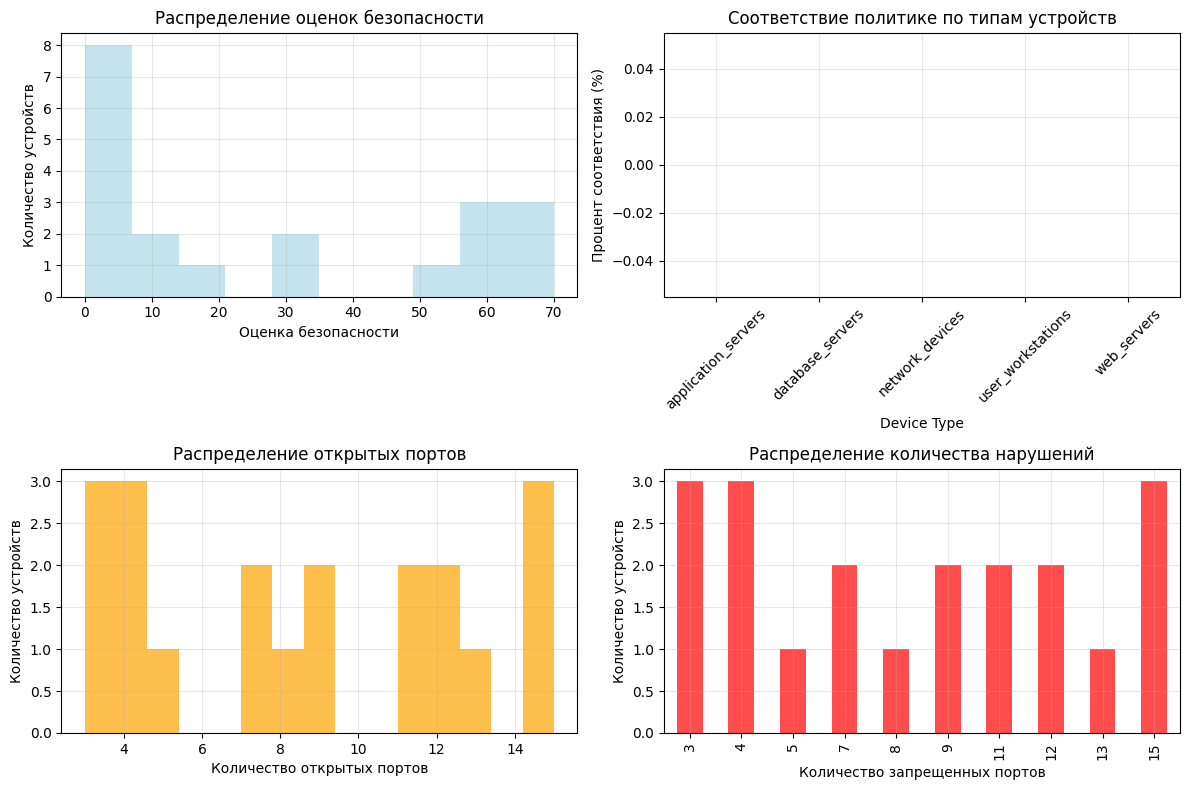

In [ ]:
import json
import pandas as pd
import random
from datetime import datetime

class NetworkAuditor:
    def __init__(self):
        self.devices = []
        self.white_list_ports = {
            'web_servers': [80, 443, 22],
            'database_servers': [22, 3306, 5432],
            'application_servers': [22, 8080, 8443],
            'user_workstations': [22, 80, 443, 3389],
            'network_devices': [22, 23, 161]  # SSH, Telnet, SNMP
        }

        self.generate_sample_devices()

    def generate_sample_devices(self, count=20):
        """Генерация тестовых устройств сети"""
        device_types = ['web_servers', 'database_servers', 'application_servers',
                       'user_workstations', 'network_devices']

        for i in range(count):
            device_type = device_types[i % len(device_types)]
            hostname = f"{device_type.split('_')[0]}-{i+1:02d}.company.local"
            ip = f"10.0.{i//256}.{i%256 + 1}"

            # Генерируем случайные открытые порты
            all_ports = list(range(1, 10000))
            open_ports = sorted(random.sample(all_ports, random.randint(3, 15)))

            device = {
                'hostname': hostname,
                'ip_address': ip,
                'device_type': device_type,
                'open_ports': open_ports,
                'last_audit': datetime.now().isoformat(),
                'operating_system': random.choice(['Linux', 'Windows', 'Cisco IOS', 'FreeBSD'])
            }

            self.devices.append(device)

    def export_to_json(self, filename='network_config.json'):
        """Экспорт конфигурации в JSON"""
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(self.devices, f, indent=2, ensure_ascii=False)

        print(f"✅ Конфигурация экспортирована в {filename}")
        return filename

    def load_from_json(self, filename='network_config.json'):
        """Загрузка конфигурации из JSON"""
        try:
            with open(filename, 'r', encoding='utf-8') as f:
                self.devices = json.load(f)
            print(f"✅ Конфигурация загружена из {filename}")
            return True
        except FileNotFoundError:
            print(f"❌ Файл {filename} не найден")
            return False

    def audit_devices(self):
        """Аудит устройств на соответствие белому списку"""
        audit_results = []

        print("🔍 ЗАПУСК СЕТЕВОГО АУДИТА...")
        print("=" * 80)

        for device in self.devices:
            device_type = device['device_type']
            open_ports = set(device['open_ports'])
            allowed_ports = set(self.white_list_ports.get(device_type, []))

            # Находим запрещенные порты
            forbidden_ports = open_ports - allowed_ports
            missing_ports = allowed_ports - open_ports  # Ожидаемые, но закрытые

            # Оценка безопасности
            security_score = 100
            if forbidden_ports:
                security_score -= len(forbidden_ports) * 10

            status = "✅ СООТВЕТСТВУЕТ" if not forbidden_ports else "❌ НАРУШЕНИЕ"

            result = {
                'Hostname': device['hostname'],
                'IP Address': device['ip_address'],
                'Device Type': device_type,
                'Open Ports': len(open_ports),
                'Forbidden Ports': len(forbidden_ports),
                'Security Score': max(security_score, 0),
                'Status': status,
                'Forbidden Ports List': sorted(forbidden_ports),
                'Missing Ports': sorted(missing_ports)
            }

            audit_results.append(result)

            # Вывод результата для устройства
            print(f"{status} {device['hostname']} ({device['ip_address']})")
            print(f"   Открыто портов: {len(open_ports)}, Запрещенных: {len(forbidden_ports)}")
            if forbidden_ports:
                print(f"   ⚠️  Запрещенные порты: {sorted(forbidden_ports)}")
            if missing_ports:
                print(f"   ℹ️  Ожидаемые, но закрытые: {sorted(missing_ports)}")
            print()

        return audit_results

    def generate_audit_report(self, audit_results):
        """Генерация отчета аудита"""
        df = pd.DataFrame(audit_results)

        # Общая статистика
        total_devices = len(audit_results)
        compliant_devices = len([r for r in audit_results if r['Status'] == '✅ СООТВЕТСТВУЕТ'])
        compliance_rate = (compliant_devices / total_devices) * 100

        print("📊 ОТЧЕТ АУДИТА БЕЗОПАСНОСТИ СЕТИ")
        print("=" * 80)
        print(f"Всего устройств: {total_devices}")
        print(f"Соответствующих политике: {compliant_devices}")
        print(f"Уровень соответствия: {compliance_rate:.1f}%")

        # Статистика по типам устройств
        print("\n📈 СТАТИСТИКА ПО ТИПАМ УСТРОЙСТВ:")
        type_stats = df.groupby('Device Type').agg({
            'Security Score': 'mean',
            'Status': lambda x: (x == '✅ СООТВЕТСТВУЕТ').sum()
        }).round(1)

        type_stats['Total'] = df['Device Type'].value_counts()
        type_stats['Compliance Rate'] = (type_stats['Status'] / type_stats['Total'] * 100).round(1)
        print(type_stats)

        # Устройства с нарушениями
        violations = df[df['Forbidden Ports'] > 0]
        if not violations.empty:
            print("\n🚨 УСТРОЙСТВА С НАРУШЕНИЯМИ ПОЛИТИКИ:")
            print(violations[['Hostname', 'IP Address', 'Device Type', 'Forbidden Ports']].to_string(index=False))

        # Рекомендации
        self.generate_recommendations(df)

        return df

    def generate_recommendations(self, df):
        """Генерация рекомендаций по безопасности"""
        print("\n💡 РЕКОМЕНДАЦИИ ПО БЕЗОПАСНОСТИ:")

        violations = df[df['Forbidden Ports'] > 0]

        if violations.empty:
            print("✅ Все устройства соответствуют политике безопасности. Отличная работа!")
            return

        # Общие рекомендации
        print("1. 🔒 Закройте неиспользуемые порты на устройствах:")
        for _, device in violations.iterrows():
            if device['Forbidden Ports'] > 0:
                print(f"   - {device['Hostname']}: порты {device['Forbidden Ports List']}")

        print("\n2. 🛡️  Настройте фаервол для блокировки неавторизованных портов")
        print("3. 📊 Регулярно проводите сканирование портов для мониторинга")
        print("4. 🔄 Обновите белые списки портов для соответствующих типов устройств")

        # Специфические рекомендации
        common_violations = {}
        for _, device in violations.iterrows():
            for port in device['Forbidden Ports List']:
                common_violations[port] = common_violations.get(port, 0) + 1

        if common_violations:
            print("\n5. 🎯 Наиболее часто нарушаемые порты:")
            for port, count in sorted(common_violations.items(), key=lambda x: x[1], reverse=True)[:5]:
                print(f"   - Порт {port}: {count} устройств")

                # Рекомендации для конкретных портов
                if port == 21:
                    print("     ⚠️  FTP - используйте SFTP или FTPS для безопасности")
                elif port == 23:
                    print("     ⚠️  Telnet - замените на SSH")
                elif port == 135:
                    print("     ⚠️  RPC - ограничьте доступ к этому порту")

def demonstrate_network_audit():
    """Демонстрация сетевого аудита"""
    auditor = NetworkAuditor()

    # Экспортируем конфигурацию
    config_file = auditor.export_to_json()

    # Загружаем обратно (демонстрация)
    auditor.load_from_json(config_file)

    # Проводим аудит
    audit_results = auditor.audit_devices()

    # Генерируем отчет
    report_df = auditor.generate_audit_report(audit_results)

    # Визуализация результатов
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 8))

    # График 1: Распределение оценок безопасности
    plt.subplot(2, 2, 1)
    report_df['Security Score'].hist(bins=10, alpha=0.7, color='lightblue')
    plt.title('Распределение оценок безопасности')
    plt.xlabel('Оценка безопасности')
    plt.ylabel('Количество устройств')
    plt.grid(alpha=0.3)

    # График 2: Соответствие по типам устройств
    plt.subplot(2, 2, 2)
    compliance_by_type = report_df.groupby('Device Type')['Status'].apply(
        lambda x: (x == '✅ СООТВЕТСТВУЕТ').mean() * 100
    )
    compliance_by_type.plot(kind='bar', color='lightgreen')
    plt.title('Соответствие политике по типам устройств')
    plt.ylabel('Процент соответствия (%)')
    plt.xticks(rotation=45)
    plt.grid(alpha=0.3)

    # График 3: Количество открытых портов
    plt.subplot(2, 2, 3)
    report_df['Open Ports'].hist(bins=15, alpha=0.7, color='orange')
    plt.title('Распределение открытых портов')
    plt.xlabel('Количество открытых портов')
    plt.ylabel('Количество устройств')
    plt.grid(alpha=0.3)

    # График 4: Запрещенные порты
    plt.subplot(2, 2, 4)
    forbidden_counts = report_df['Forbidden Ports'].value_counts().sort_index()
    forbidden_counts.plot(kind='bar', color='red', alpha=0.7)
    plt.title('Распределение количества нарушений')
    plt.xlabel('Количество запрещенных портов')
    plt.ylabel('Количество устройств')
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    demonstrate_network_audit()

16. Брутфорс-паролей (эмуляция)

⚡ СРАВНЕНИЕ СКОРОСТИ АТАК
Тестовый пароль: 'cat', Хэш: d077f244def8a70e5ea758bd8352fcd8

1. АТАКА ПО СЛОВАРЮ:
🔓 Запуск атаки по словарю на хэш d077f244def8a70e5ea758bd8352fcd8...
❌ Пароль не найден в словаре
   Попыток: 15, Время: 0.00 секунд

2. BRUTE FORCE АТАКА:
   Максимальная длина: 3
🔓 Запуск brute force атаки (макс. длина: 3)...
✅ Пароль найден: 'cat'
   Попыток: 3944, Время: 0.00 секунд

   Максимальная длина: 4
🔓 Запуск brute force атаки (макс. длина: 4)...
✅ Пароль найден: 'cat'
   Попыток: 3944, Время: 0.00 секунд

   Максимальная длина: 5
🔓 Запуск brute force атаки (макс. длина: 5)...
✅ Пароль найден: 'cat'
   Попыток: 3944, Время: 0.00 секунд



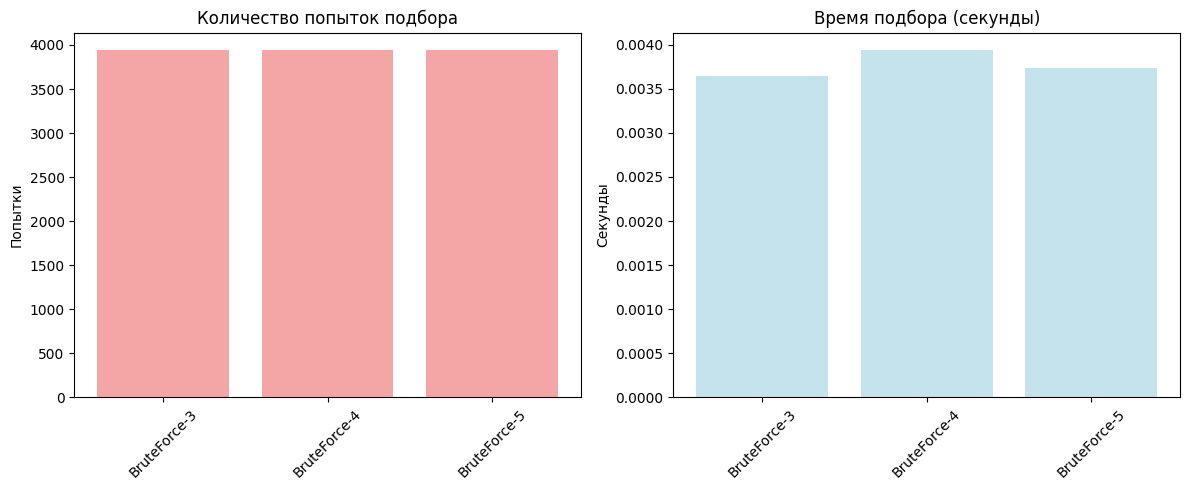


🛡️  РЕКОМЕНДАЦИИ ПО БЕЗОПАСНОСТИ ПАРОЛЕЙ:
⚠️  ОПАСНО: Пароль взломан менее чем за 1 секунду!
💡 Рекомендации:
   - Используйте пароли длиной не менее 8 символов
   - Комбинируйте буквы, цифры и специальные символы
   - Избегайте простых слов и последовательностей

🔒 ОБЩИЕ ПРАВИЛА БЕЗОПАСНЫХ ПАРОЛЕЙ:
   1. Длина не менее 12 символов
   2. Комбинация букв (разных регистров), цифр, спецсимволов
   3. Не использовать личную информацию
   4. Уникальный пароль для каждой службы
   5. Использовать менеджер паролей
   6. Включить двухфакторную аутентификацию

🔐 ПРОВЕРКА СТОЙКОСТИ ПАРОЛЕЙ:

🔍 АНАЛИЗ ПАРОЛЯ: 'password'
   Оценка стойкости: ❌ СЛАБЫЙ (0/5)
   ✅ Хорошая длина
   ⚠️  Добавьте разные типы символов
   ❌ Слишком распространенный пароль


🔍 АНАЛИЗ ПАРОЛЯ: '123456'
   Оценка стойкости: ❌ СЛАБЫЙ (0/5)
   ⚠️  Слишком короткий пароль
   ⚠️  Добавьте разные типы символов
   ❌ Слишком распространенный пароль


🔍 АНАЛИЗ ПАРОЛЯ: 'Secret123!'
   Оценка стойкости: 👍 СИЛЬНЫЙ (4/5)
   ✅ Хорошая дли

In [ ]:
import hashlib
import time
import itertools
import string
import matplotlib.pyplot as plt

class PasswordCracker:
    def __init__(self):
        self.common_passwords = [
            'password', '123456', '12345678', '1234', 'qwerty',
            'admin', 'letmein', 'welcome', 'monkey', 'sunshine',
            'password1', '1234567', '123456789', 'abc123', 'password123'
        ]

        # Тестовая хэш-таблица (пароль -> хэш)
        self.test_hashes = {
            'admin': hashlib.md5('admin'.encode()).hexdigest(),
            '123456': hashlib.md5('123456'.encode()).hexdigest(),
            'password': hashlib.md5('password'.encode()).hexdigest(),
            'hello': hashlib.md5('hello'.encode()).hexdigest(),
            'secret': hashlib.md5('secret'.encode()).hexdigest(),
        }

    def hash_password(self, password, algorithm='md5'):
        """Хэширование пароля"""
        if algorithm == 'md5':
            return hashlib.md5(password.encode()).hexdigest()
        elif algorithm == 'sha1':
            return hashlib.sha1(password.encode()).hexdigest()
        elif algorithm == 'sha256':
            return hashlib.sha256(password.encode()).hexdigest()
        else:
            raise ValueError(f"Неизвестный алгоритм: {algorithm}")

    def dictionary_attack(self, target_hash, wordlist=None, algorithm='md5'):
        """Атака по словарю"""
        if wordlist is None:
            wordlist = self.common_passwords

        print(f"🔓 Запуск атаки по словарю на хэш {target_hash}...")
        start_time = time.time()
        attempts = 0

        for password in wordlist:
            attempts += 1
            hashed = self.hash_password(password, algorithm)

            if hashed == target_hash:
                elapsed = time.time() - start_time
                print(f"✅ Пароль найден: '{password}'")
                print(f"   Попыток: {attempts}, Время: {elapsed:.2f} секунд")
                return password, attempts, elapsed

        elapsed = time.time() - start_time
        print(f"❌ Пароль не найден в словаре")
        print(f"   Попыток: {attempts}, Время: {elapsed:.2f} секунд")
        return None, attempts, elapsed

    def brute_force_attack(self, target_hash, max_length=4, charset=None, algorithm='md5'):
        """Атака полным перебором (brute force)"""
        if charset is None:
            charset = string.ascii_lowercase + string.digits

        print(f"🔓 Запуск brute force атаки (макс. длина: {max_length})...")
        start_time = time.time()
        attempts = 0

        for length in range(1, max_length + 1):
            for candidate in itertools.product(charset, repeat=length):
                password = ''.join(candidate)
                attempts += 1
                hashed = self.hash_password(password, algorithm)

                if attempts % 10000 == 0:  # Прогресс каждые 10000 попыток
                    print(f"   Проверено: {attempts} комбинаций...")

                if hashed == target_hash:
                    elapsed = time.time() - start_time
                    print(f"✅ Пароль найден: '{password}'")
                    print(f"   Попыток: {attempts}, Время: {elapsed:.2f} секунд")
                    return password, attempts, elapsed

        elapsed = time.time() - start_time
        print(f"❌ Пароль не найден (максимальная длина: {max_length})")
        print(f"   Попыток: {attempts}, Время: {elapsed:.2f} секунд")
        return None, attempts, elapsed

    def demonstrate_attack_speed(self):
        """Демонстрация скорости различных атак"""
        results = []

        print("⚡ СРАВНЕНИЕ СКОРОСТИ АТАК")
        print("=" * 60)

        # Тестируем на простом пароле
        test_password = 'cat'
        test_hash = self.hash_password(test_password)

        print(f"Тестовый пароль: '{test_password}', Хэш: {test_hash}")
        print()

        # Атака по словарю
        print("1. АТАКА ПО СЛОВАРЮ:")
        result_dict = self.dictionary_attack(test_hash)
        if result_dict[0]:
            results.append(('Dictionary', result_dict[1], result_dict[2]))
        print()

        # Brute force с разной длиной
        print("2. BRUTE FORCE АТАКА:")
        for max_len in [3, 4, 5]:
            print(f"   Максимальная длина: {max_len}")
            result_bf = self.brute_force_attack(test_hash, max_length=max_len)
            if result_bf[0]:
                results.append((f'BruteForce-{max_len}', result_bf[1], result_bf[2]))
            print()

        # Визуализация результатов
        if results:
            self.visualize_attack_results(results)

        return results

    def visualize_attack_results(self, results):
        """Визуализация результатов атак"""
        methods = [r[0] for r in results]
        attempts = [r[1] for r in results]
        times = [r[2] for r in results]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

        # График попыток
        ax1.bar(methods, attempts, color='lightcoral', alpha=0.7)
        ax1.set_title('Количество попыток подбора')
        ax1.set_ylabel('Попытки')
        ax1.tick_params(axis='x', rotation=45)

        # График времени
        ax2.bar(methods, times, color='lightblue', alpha=0.7)
        ax2.set_title('Время подбора (секунды)')
        ax2.set_ylabel('Секунды')
        ax2.tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

        # Вывод рекомендаций по безопасности
        self.security_recommendations(max(attempts), max(times))

    def security_recommendations(self, max_attempts, max_time):
        """Рекомендации по безопасности паролей"""
        print("\n🛡️  РЕКОМЕНДАЦИИ ПО БЕЗОПАСНОСТИ ПАРОЛЕЙ:")
        print("=" * 60)

        if max_time < 1:
            print("⚠️  ОПАСНО: Пароль взломан менее чем за 1 секунду!")
            print("💡 Рекомендации:")
            print("   - Используйте пароли длиной не менее 8 символов")
            print("   - Комбинируйте буквы, цифры и специальные символы")
            print("   - Избегайте простых слов и последовательностей")
        elif max_time < 10:
            print("⚠️  Пароль может быть взломан за несколько секунд")
            print("💡 Рекомендации:")
            print("   - Увеличьте длину пароля до 12+ символов")
            print("   - Используйте разные регистры букв")
        else:
            print("✅ Пароль достаточно устойчив к brute force атакам")

        print("\n🔒 ОБЩИЕ ПРАВИЛА БЕЗОПАСНЫХ ПАРОЛЕЙ:")
        print("   1. Длина не менее 12 символов")
        print("   2. Комбинация букв (разных регистров), цифр, спецсимволов")
        print("   3. Не использовать личную информацию")
        print("   4. Уникальный пароль для каждой службы")
        print("   5. Использовать менеджер паролей")
        print("   6. Включить двухфакторную аутентификацию")

    def password_strength_checker(self, password):
        """Проверка стойкости пароля"""
        score = 0
        feedback = []

        # Длина пароля
        if len(password) >= 12:
            score += 3
        elif len(password) >= 8:
            score += 2
            feedback.append("✅ Хорошая длина")
        else:
            feedback.append("⚠️  Слишком короткий пароль")

        # Разнообразие символов
        has_upper = any(c.isupper() for c in password)
        has_lower = any(c.islower() for c in password)
        has_digit = any(c.isdigit() for c in password)
        has_special = any(not c.isalnum() for c in password)

        char_types = sum([has_upper, has_lower, has_digit, has_special])
        if char_types >= 3:
            score += 2
            feedback.append("✅ Хорошее разнообразие символов")
        else:
            feedback.append("⚠️  Добавьте разные типы символов")

        # Проверка на common passwords
        if password.lower() in self.common_passwords:
            score = 0
            feedback.append("❌ Слишком распространенный пароль")

        # Оценка стойкости
        if score >= 5:
            strength = "💪 ОЧЕНЬ СИЛЬНЫЙ"
        elif score >= 3:
            strength = "👍 СИЛЬНЫЙ"
        elif score >= 1:
            strength = "⚠️  СРЕДНИЙ"
        else:
            strength = "❌ СЛАБЫЙ"

        print(f"\n🔍 АНАЛИЗ ПАРОЛЯ: '{password}'")
        print(f"   Оценка стойкости: {strength} ({score}/5)")
        for fb in feedback:
            print(f"   {fb}")

def demonstrate_password_security():
    """Демонстрация безопасности паролей"""
    cracker = PasswordCracker()

    # Демонстрация атак
    results = cracker.demonstrate_attack_speed()

    # Проверка стойкости паролей
    print("\n🔐 ПРОВЕРКА СТОЙКОСТИ ПАРОЛЕЙ:")
    test_passwords = ['password', '123456', 'Secret123!', 'MySuperStrongPassword2024!']

    for pwd in test_passwords:
        cracker.password_strength_checker(pwd)
        print()

if __name__ == "__main__":
    demonstrate_password_security()

17. Сбор метрик трафика

📊 Имитация сбора метрик трафика за 30 секунд...
   10 секунд: 1246 байт/сек
   20 секунд: 1441 байт/сек
✅ Сбор метрик завершен!


/tmp/ipython-input-3040145627.py:102: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3040145627.py:102: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3040145627.py:102: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3040145627.py:102: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/p

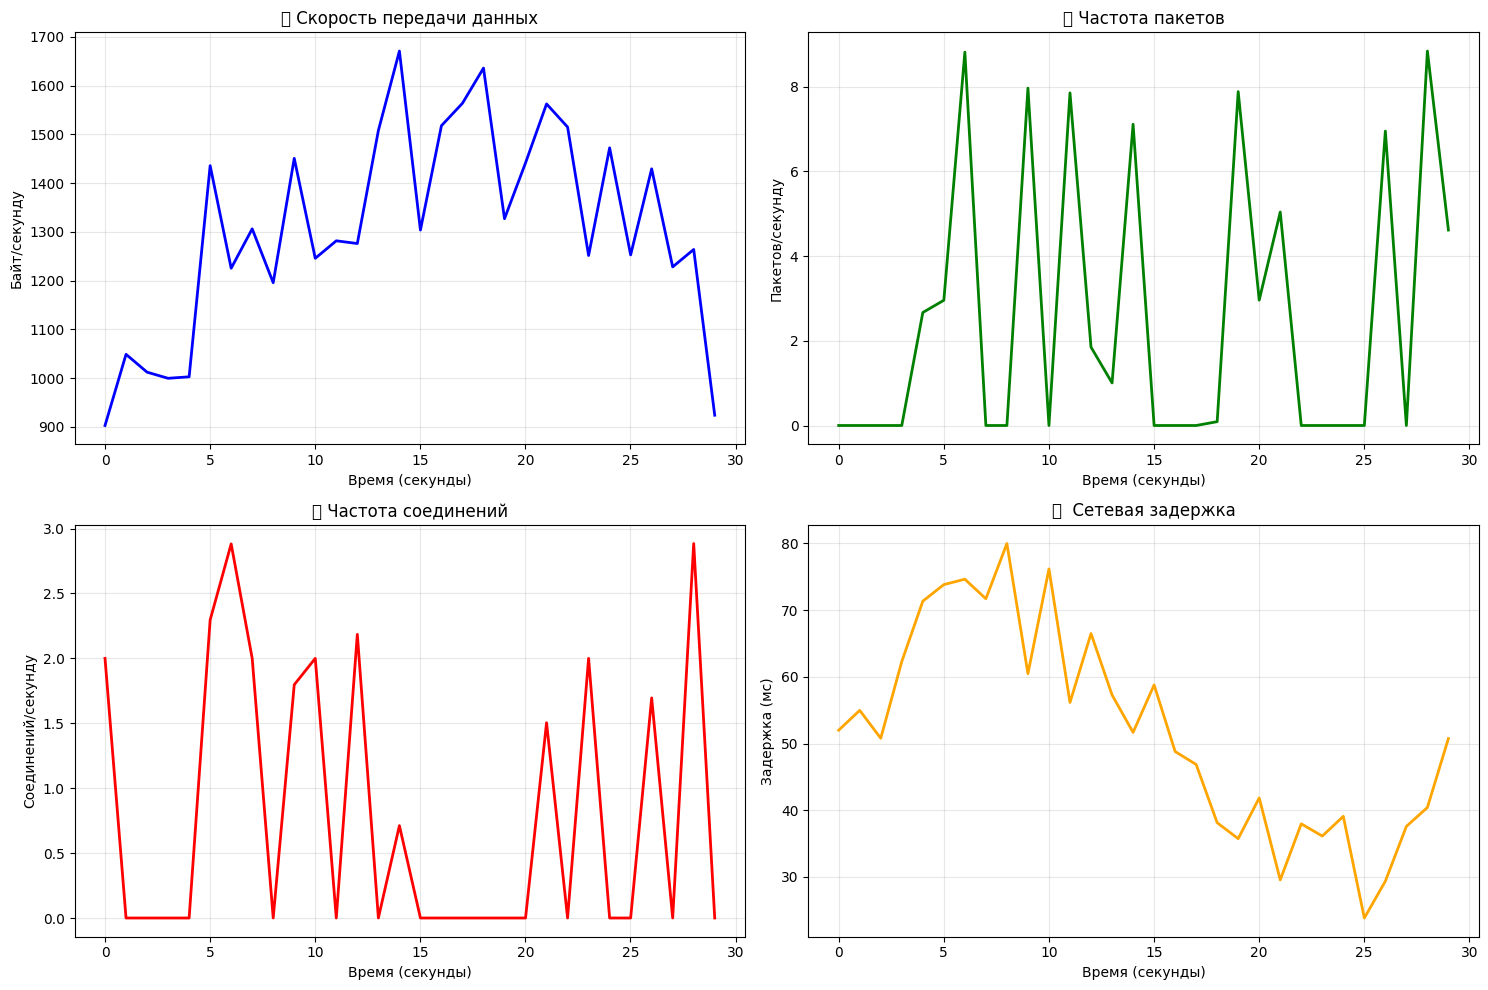


📊 СТАТИСТИКА СЕТЕВОГО ТРАФИКА
      bytes_per_sec  packets_per_sec  connections_per_sec  latency_ms
mean        1308.42             2.55                 0.80       51.82
std          210.60             3.33                 1.06       15.51
min          903.00             0.00                 0.00       23.83
max         1670.79             8.84                 2.88       79.99

🔍 ПОИСК АНОМАЛИЙ В ТРАФИКЕ
----------------------------------------
✅ Аномальных пиков не обнаружено

📈 АНАЛИЗ ТРЕНДОВ ТРАФИКА
----------------------------------------
Тренд трафика: 📈 ВОСХОДЯЩИЙ (наклон: 8.94 байт/сек²)
Прогноз через 10 секунд: 1527 байт/сек


In [ ]:
import time
import random
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque
import numpy as np

class TrafficMetricsCollector:
    def __init__(self, duration=60):
        self.duration = duration
        self.metrics = {
            'timestamps': [],
            'bytes_per_sec': [],
            'packets_per_sec': [],
            'connections_per_sec': [],
            'latency_ms': []
        }
        self.real_time_data = deque(maxlen=duration)

    def simulate_traffic(self):
        """Имитация сетевого трафика"""
        print(f"📊 Имитация сбора метрик трафика за {self.duration} секунд...")
        print("=" * 60)

        start_time = time.time()
        current_time = start_time

        while current_time - start_time < self.duration:
            # Генерируем реалистичные метрики трафика
            timestamp = current_time - start_time

            # Базовые метрики с случайными колебаниями
            base_traffic = 1000 + 500 * np.sin(timestamp / 10)  # Синусоидальный тренд
            bytes_sec = max(0, base_traffic + random.randint(-200, 200))
            packets_sec = max(0, bytes_sec / 1500 + random.randint(-10, 10))  # Примерно 1500 байт/пакет
            connections_sec = max(0, packets_sec / 10 + random.randint(-2, 2))
            latency = 50 + 20 * np.sin(timestamp / 5) + random.randint(-10, 10)  # Колебания задержки

            # Сохраняем метрики
            self.metrics['timestamps'].append(timestamp)
            self.metrics['bytes_per_sec'].append(bytes_sec)
            self.metrics['packets_per_sec'].append(packets_sec)
            self.metrics['connections_per_sec'].append(connections_sec)
            self.metrics['latency_ms'].append(latency)

            # Реал-тайм данные для демонстрации
            self.real_time_data.append({
                'timestamp': timestamp,
                'bytes_sec': bytes_sec,
                'packets_sec': packets_sec
            })

            # Вывод прогресса
            if int(timestamp) % 10 == 0 and int(timestamp) > 0:
                print(f"   {int(timestamp)} секунд: {bytes_sec:.0f} байт/сек")

            time.sleep(1)  # Имитация 1 секунды
            current_time = time.time()

        print("✅ Сбор метрик завершен!")

    def visualize_metrics(self):
        """Визуализация собранных метрик"""
        if not self.metrics['timestamps']:
            print("❌ Нет данных для визуализации")
            return

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

        # График 1: Байты в секунду
        ax1.plot(self.metrics['timestamps'], self.metrics['bytes_per_sec'],
                color='blue', linewidth=2)
        ax1.set_title('📈 Скорость передачи данных')
        ax1.set_xlabel('Время (секунды)')
        ax1.set_ylabel('Байт/секунду')
        ax1.grid(True, alpha=0.3)

        # График 2: Пакеты в секунду
        ax2.plot(self.metrics['timestamps'], self.metrics['packets_per_sec'],
                color='green', linewidth=2)
        ax2.set_title('📦 Частота пакетов')
        ax2.set_xlabel('Время (секунды)')
        ax2.set_ylabel('Пакетов/секунду')
        ax2.grid(True, alpha=0.3)

        # График 3: Соединения в секунду
        ax3.plot(self.metrics['timestamps'], self.metrics['connections_per_sec'],
                color='red', linewidth=2)
        ax3.set_title('🔗 Частота соединений')
        ax3.set_xlabel('Время (секунды)')
        ax3.set_ylabel('Соединений/секунду')
        ax3.grid(True, alpha=0.3)

        # График 4: Задержка
        ax4.plot(self.metrics['timestamps'], self.metrics['latency_ms'],
                color='orange', linewidth=2)
        ax4.set_title('⏱️  Сетевая задержка')
        ax4.set_xlabel('Время (секунды)')
        ax4.set_ylabel('Задержка (мс)')
        ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def calculate_statistics(self):
        """Расчет статистики по метрикам"""
        df = pd.DataFrame(self.metrics)

        print("\n📊 СТАТИСТИКА СЕТЕВОГО ТРАФИКА")
        print("=" * 60)

        stats = df.agg({
            'bytes_per_sec': ['mean', 'std', 'min', 'max'],
            'packets_per_sec': ['mean', 'std', 'min', 'max'],
            'connections_per_sec': ['mean', 'std', 'min', 'max'],
            'latency_ms': ['mean', 'std', 'min', 'max']
        }).round(2)

        print(stats)

        # Обнаружение аномалий
        self.detect_anomalies(df)

        return stats

    def detect_anomalies(self, df):
        """Обнаружение аномалий в трафике"""
        print("\n🔍 ПОИСК АНОМАЛИЙ В ТРАФИКЕ")
        print("-" * 40)

        # Простые правила для обнаружения аномалий
        bytes_mean = df['bytes_per_sec'].mean()
        bytes_std = df['bytes_per_sec'].std()

        # Аномалии: значения beyond 2 стандартных отклонений
        anomaly_threshold = bytes_mean + 2 * bytes_std
        anomalies = df[df['bytes_per_sec'] > anomaly_threshold]

        if not anomalies.empty:
            print(f"⚠️  Обнаружено {len(anomalies)} аномальных пиков трафика:")
            for _, anomaly in anomalies.iterrows():
                print(f"   Время: {anomaly['timestamps']:.0f}с - {anomaly['bytes_per_sec']:.0f} байт/сек "
                      f"(порог: {anomaly_threshold:.0f})")
        else:
            print("✅ Аномальных пиков не обнаружено")

        # Анализ трендов
        self.analyze_trends(df)

    def analyze_trends(self, df):
        """Анализ трендов трафика"""
        print("\n📈 АНАЛИЗ ТРЕНДОВ ТРАФИКА")
        print("-" * 40)

        # Простой анализ тренда (линейная регрессия)
        x = np.array(df['timestamps'])
        y_bytes = np.array(df['bytes_per_sec'])

        # Линейная регрессия
        slope, intercept = np.polyfit(x, y_bytes, 1)

        if slope > 5:
            trend = "📈 ВОСХОДЯЩИЙ"
        elif slope < -5:
            trend = "📉 НИСХОДЯЩИЙ"
        else:
            trend = "➡️  СТАБИЛЬНЫЙ"

        print(f"Тренд трафика: {trend} (наклон: {slope:.2f} байт/сек²)")

        # Прогноз на следующие 10 секунд
        if len(x) > 0:
            last_time = x[-1]
            forecast_time = last_time + 10
            forecast_value = slope * forecast_time + intercept

            print(f"Прогноз через 10 секунд: {forecast_value:.0f} байт/сек")

    def real_time_demonstration(self):
        """Демонстрация реального времени с анимацией"""
        try:
            import matplotlib.animation as animation
        except ImportError:
            print("❌ Для анимации требуется matplotlib.animation")
            return

        fig, ax = plt.subplots(figsize=(10, 6))
        x_data, y_data = [], []

        def animate(frame):
            # Имитация новых данных
            if frame < self.duration:
                new_value = 1000 + 500 * np.sin(frame / 10) + random.randint(-200, 200)
                x_data.append(frame)
                y_data.append(new_value)

                ax.clear()
                ax.plot(x_data, y_data, 'b-', linewidth=2)
                ax.set_title(f'📊 Реал-тайм мониторинг трафика ({frame}с)')
                ax.set_xlabel('Время (секунды)')
                ax.set_ylabel('Байт/секунду')
                ax.grid(True, alpha=0.3)
                ax.set_ylim(0, 2000)

        print("\n🎬 ЗАПУСК РЕАЛ-ТАЙМ ДЕМОНСТРАЦИИ...")
        anim = animation.FuncAnimation(fig, animate, frames=self.duration,
                                     interval=1000, repeat=False)
        plt.show()

def demonstrate_traffic_metrics():
    """Демонстрация сбора метрик трафика"""
    collector = TrafficMetricsCollector(duration=30)  # 30 секунд для демонстрации

    # Собираем метрики
    collector.simulate_traffic()

    # Визуализируем
    collector.visualize_metrics()

    # Статистика
    collector.calculate_statistics()

    # Реал-тайм демонстрация (опционально)
    # collector.real_time_demonstration()

if __name__ == "__main__":
    demonstrate_traffic_metrics()

18. Визуализация сетевой топологии

/tmp/ipython-input-3353189176.py:103: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


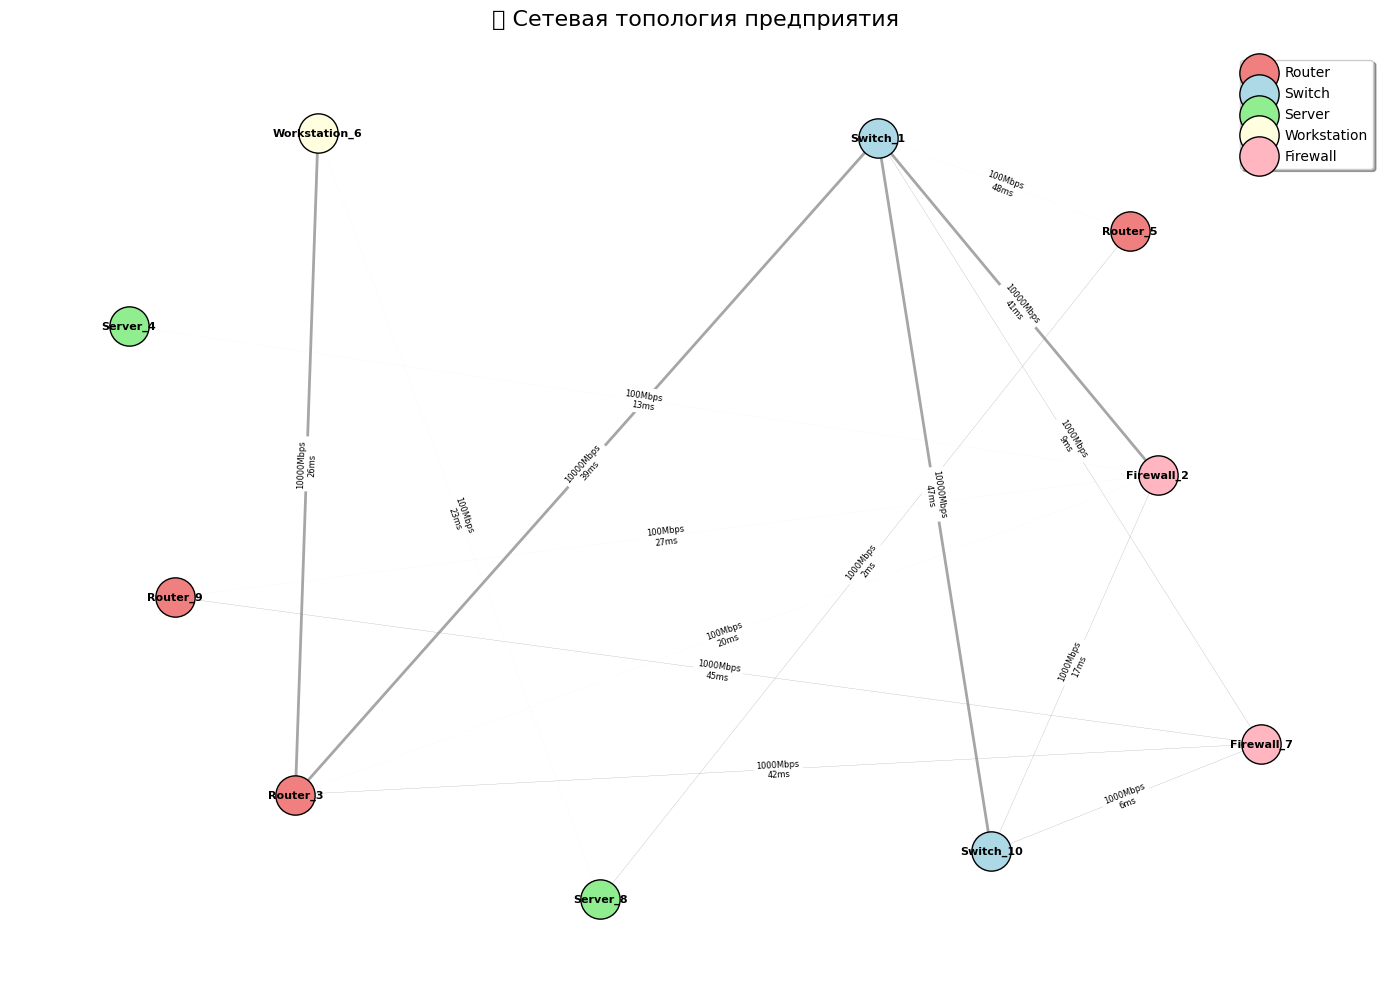

🔍 АНАЛИЗ СЕТЕВОЙ ТОПОЛОГИИ
Количество узлов: 10
Количество соединений: 15
Плотность сети: 0.333
Связность: Связная
Диаметр сети: 4
Средний путь: 1.96

🎯 КРИТИЧЕСКИЕ УЗЛЫ:
Наиболее связанный: Switch_1 (степень: 5)
Наиболее центральный: Firewall_2 (betweenness: 0.324)

📊 ПРОПУСКНАЯ СПОСОБНОСТЬ:
Суммарная пропускная способность: 46500 Mbps
Средняя задержка: 27.0 ms

🛡️  АНАЛИЗ УЯЗВИМОСТЕЙ ТОПОЛОГИИ
----------------------------------------
⚠️  ТОЧКИ ОТКАЗА (высокая степень связности):
   - Switch_1: 5 соединений
   - Firewall_2: 5 соединений
   - Router_3: 4 соединений
   - Firewall_7: 4 соединений
   - Switch_10: 3 соединений

🚨 ОДИНОЧНЫЕ ТОЧКИ ОТКАЗА:
   - Firewall_2: отказ разделит сеть

💡 РЕКОМЕНДАЦИИ ПО УЛУЧШЕНИЮ ТОПОЛОГИИ:
--------------------------------------------------
1. 🔄 Добавьте избыточные соединения для повышения отказоустойчивости
2. ⚖️  Рассмотрите балансировку нагрузки между узлами
3. 🏷️  Рассмотрите сегментацию сети на VLAN для безопасности
4. 📊 Регулярно проводите аудит

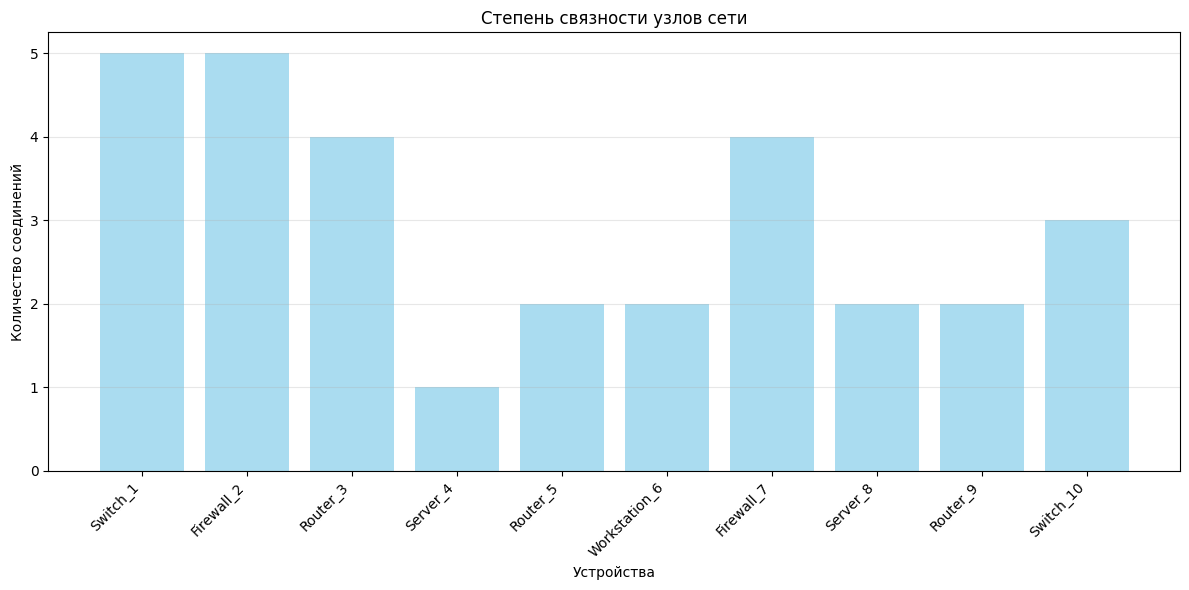

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import pandas as pd

class NetworkTopology:
    def __init__(self, num_nodes=8):
        self.num_nodes = num_nodes
        self.G = nx.Graph()
        self.generate_topology()

    def generate_topology(self):
        """Генерация случайной сетевой топологии"""
        # Создаем узлы (устройства)
        devices = []
        device_types = ['Router', 'Switch', 'Server', 'Workstation', 'Firewall']

        for i in range(self.num_nodes):
            device_type = random.choice(device_types)
            device_name = f"{device_type}_{i+1}"
            devices.append((i, {
                'name': device_name,
                'type': device_type,
                'ip': f'192.168.1.{i+1}',
                'os': random.choice(['Linux', 'Windows', 'Cisco IOS', 'FreeBSD'])
            }))

        # Добавляем узлы в граф
        self.G.add_nodes_from(devices)

        # Создаем связи (сетевые соединения)
        # Гарантируем связность графа
        for i in range(1, self.num_nodes):
            # Соединяем каждый узел с хотя бы одним другим
            target = random.randint(0, i-1)
            bandwidth = random.choice([100, 1000, 10000])  # Mbps
            latency = random.randint(1, 50)  # ms

            self.G.add_edge(i, target,
                           bandwidth=bandwidth,
                           latency=latency,
                           type='Ethernet')

        # Добавляем случайные дополнительные связи
        additional_edges = random.randint(self.num_nodes // 2, self.num_nodes)
        for _ in range(additional_edges):
            node1, node2 = random.sample(range(self.num_nodes), 2)
            if not self.G.has_edge(node1, node2):
                bandwidth = random.choice([100, 1000, 10000])
                latency = random.randint(1, 50)
                self.G.add_edge(node1, node2,
                               bandwidth=bandwidth,
                               latency=latency,
                               type=random.choice(['Ethernet', 'Fiber', 'Wireless']))

    def visualize_topology(self):
        """Визуализация топологии сети"""
        plt.figure(figsize=(14, 10))

        # Позиционирование узлов
        pos = nx.spring_layout(self.G, k=3, iterations=50, seed=42)

        # Цвета для разных типов устройств
        device_colors = {
            'Router': 'lightcoral',
            'Switch': 'lightblue',
            'Server': 'lightgreen',
            'Workstation': 'lightyellow',
            'Firewall': 'lightpink'
        }

        # Рисуем узлы
        for device_type, color in device_colors.items():
            nodes_of_type = [node for node, data in self.G.nodes(data=True)
                           if data['type'] == device_type]
            nx.draw_networkx_nodes(self.G, pos,
                                 nodelist=nodes_of_type,
                                 node_color=color,
                                 node_size=800,
                                 edgecolors='black',
                                 label=device_type)

        # Рисуем ребра с разной толщиной по bandwidth
        edge_widths = [self.G[u][v]['bandwidth'] / 5000 for u, v in self.G.edges()]

        nx.draw_networkx_edges(self.G, pos,
                             width=edge_widths,
                             alpha=0.7,
                             edge_color='gray')

        # Подписи узлов
        labels = {node: data['name'] for node, data in self.G.nodes(data=True)}
        nx.draw_networkx_labels(self.G, pos, labels, font_size=8, font_weight='bold')

        # Подписи ребер (bandwidth и latency)
        edge_labels = {(u, v): f"{self.G[u][v]['bandwidth']}Mbps\n{self.G[u][v]['latency']}ms"
                      for u, v in self.G.edges()}
        nx.draw_networkx_edge_labels(self.G, pos, edge_labels, font_size=6)

        plt.title("🌐 Сетевая топология предприятия", size=16, pad=20)
        plt.legend(scatterpoints=1, frameon=True, shadow=True)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    def analyze_topology(self):
        """Анализ топологии сети"""
        print("🔍 АНАЛИЗ СЕТЕВОЙ ТОПОЛОГИИ")
        print("=" * 60)

        # Основные метрики
        print(f"Количество узлов: {self.G.number_of_nodes()}")
        print(f"Количество соединений: {self.G.number_of_edges()}")
        print(f"Плотность сети: {nx.density(self.G):.3f}")
        print(f"Связность: {'Связная' if nx.is_connected(self.G) else 'Несвязная'}")

        if nx.is_connected(self.G):
            print(f"Диаметр сети: {nx.diameter(self.G)}")
            print(f"Средний путь: {nx.average_shortest_path_length(self.G):.2f}")

        # Центральность узлов
        degree_centrality = nx.degree_centrality(self.G)
        betweenness_centrality = nx.betweenness_centrality(self.G)

        # Находим наиболее важные узлы
        most_connected = max(degree_centrality, key=degree_centrality.get)
        most_central = max(betweenness_centrality, key=betweenness_centrality.get)

        print(f"\n🎯 КРИТИЧЕСКИЕ УЗЛЫ:")
        print(f"Наиболее связанный: {self.G.nodes[most_connected]['name']} "
              f"(степень: {self.G.degree[most_connected]})")
        print(f"Наиболее центральный: {self.G.nodes[most_central]['name']} "
              f"(betweenness: {betweenness_centrality[most_central]:.3f})")

        # Анализ пропускной способности
        total_bandwidth = sum(self.G[u][v]['bandwidth'] for u, v in self.G.edges())
        avg_latency = np.mean([self.G[u][v]['latency'] for u, v in self.G.edges()])

        print(f"\n📊 ПРОПУСКНАЯ СПОСОБНОСТЬ:")
        print(f"Суммарная пропускная способность: {total_bandwidth} Mbps")
        print(f"Средняя задержка: {avg_latency:.1f} ms")

        # Уязвимости
        self.identify_vulnerabilities()

    def identify_vulnerabilities(self):
        """Идентификация уязвимостей топологии"""
        print(f"\n🛡️  АНАЛИЗ УЯЗВИМОСТЕЙ ТОПОЛОГИИ")
        print("-" * 40)

        # Точки отказа (узлы с высокой степенью)
        high_degree_nodes = [node for node in self.G.nodes()
                           if self.G.degree[node] > 2]  # Более 2 соединений

        if high_degree_nodes:
            print("⚠️  ТОЧКИ ОТКАЗА (высокая степень связности):")
            for node in high_degree_nodes:
                device = self.G.nodes[node]
                print(f"   - {device['name']}: {self.G.degree[node]} соединений")

        # Одиночные точки отказа
        articulation_points = list(nx.articulation_points(self.G))
        if articulation_points:
            print("\n🚨 ОДИНОЧНЫЕ ТОЧКИ ОТКАЗА:")
            for node in articulation_points:
                device = self.G.nodes[node]
                print(f"   - {device['name']}: отказ разделит сеть")

        # Рекомендации
        self.generate_recommendations()

    def generate_recommendations(self):
        """Генерация рекомендаций по улучшению топологии"""
        print(f"\n💡 РЕКОМЕНДАЦИИ ПО УЛУЧШЕНИЮ ТОПОЛОГИИ:")
        print("-" * 50)

        # Проверка избыточности
        if nx.is_connected(self.G):
            connectivity = nx.node_connectivity(self.G)
            if connectivity == 1:
                print("1. 🔄 Добавьте избыточные соединения для повышения отказоустойчивости")
            else:
                print(f"1. ✅ Топология имеет хорошую связность ({connectivity})")

        # Балансировка нагрузки
        degrees = [self.G.degree[node] for node in self.G.nodes()]
        degree_std = np.std(degrees)

        if degree_std > 1.0:
            print("2. ⚖️  Рассмотрите балансировку нагрузки между узлами")
        else:
            print("2. ✅ Нагрузка распределена равномерно")

        # Сегментация сети
        print("3. 🏷️  Рассмотрите сегментацию сети на VLAN для безопасности")
        print("4. 📊 Регулярно проводите аудит топологии")
        print("5. 🔍 Мониторьте использование пропускной способности")

    def export_topology_report(self):
        """Экспорт отчета по топологии"""
        devices_data = []
        for node, data in self.G.nodes(data=True):
            devices_data.append({
                'Device_ID': node,
                'Name': data['name'],
                'Type': data['type'],
                'IP_Address': data['ip'],
                'OS': data['os'],
                'Connections': self.G.degree[node]
            })

        connections_data = []
        for u, v, data in self.G.edges(data=True):
            connections_data.append({
                'From': self.G.nodes[u]['name'],
                'To': self.G.nodes[v]['name'],
                'Bandwidth_Mbps': data['bandwidth'],
                'Latency_ms': data['latency'],
                'Type': data['type']
            })

        devices_df = pd.DataFrame(devices_data)
        connections_df = pd.DataFrame(connections_data)

        print("\n📋 ОТЧЕТ ПО ТОПОЛОГИИ СЕТИ")
        print("Устройства:")
        print(devices_df.to_string(index=False))

        print("\nСоединения:")
        print(connections_df.to_string(index=False))

        return devices_df, connections_df

def demonstrate_network_topology():
    """Демонстрация сетевой топологии"""
    # Создаем топологию
    topology = NetworkTopology(num_nodes=10)

    # Визуализируем
    topology.visualize_topology()

    # Анализируем
    topology.analyze_topology()

    # Экспортируем отчет
    devices_df, connections_df = topology.export_topology_report()

    # Дополнительная визуализация - степень узлов
    degrees = [topology.G.degree[node] for node in topology.G.nodes()]
    device_names = [topology.G.nodes[node]['name'] for node in topology.G.nodes()]

    plt.figure(figsize=(12, 6))
    plt.bar(device_names, degrees, color='skyblue', alpha=0.7)
    plt.title('Степень связности узлов сети')
    plt.xlabel('Устройства')
    plt.ylabel('Количество соединений')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    demonstrate_network_topology()

19. Анализ pcap файлов

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scapy.all import *
import numpy as np
import warnings
warnings.filterwarnings('ignore')

class PCAPAnalyzer:
    def __init__(self):
        self.packets = []
        self.df = None

    def load_pcap(self, filepath):
        """Загрузка pcap файла"""
        try:
            print(f"📁 Загрузка pcap файла: {filepath}")
            self.packets = rdpcap(filepath)
            print(f"✅ Загружено пакетов: {len(self.packets)}")
            return True
        except FileNotFoundError:
            print(f"❌ Файл {filepath} не найден")
            return False
        except Exception as e:
            print(f"❌ Ошибка загрузки: {e}")
            return False

    def create_sample_pcap(self, filename='sample_traffic.pcap'):
        """Создание демонстрационного pcap файла"""
        print("🔄 Создание демонстрационного pcap файла...")

        packets = []

        # Генерируем разнообразные пакеты
        for i in range(1000):
            # Случайные IP адреса
            src_ip = f"192.168.1.{random.randint(1, 50)}"
            dst_ip = f"10.0.0.{random.randint(1, 100)}"

            # Случайные порты
            src_port = random.randint(1024, 65535)
            dst_port = random.choice([80, 443, 22, 53, 21, 25])

            # Создаем IP пакет
            ip_pkt = IP(src=src_ip, dst=dst_ip)

            # Добавляем TCP или UDP
            if random.random() > 0.3:  # 70% TCP
                tcp_pkt = TCP(sport=src_port, dport=dst_port)
                packet = ip_pkt / tcp_pkt
            else:  # 30% UDP
                udp_pkt = UDP(sport=src_port, dport=dst_port)
                packet = ip_pkt / udp_pkt

            packets.append(packet)

        # Сохраняем в файл
        wrpcap(filename, packets)
        print(f"✅ Демонстрационный pcap создан: {filename}")
        return filename

    def analyze_packets(self):
        """Анализ пакетов и создание DataFrame"""
        if not self.packets:
            print("❌ Нет пакетов для анализа")
            return False

        print("🔍 Анализ пакетов...")
        packet_data = []

        for i, packet in enumerate(self.packets):
            try:
                packet_info = {
                    'packet_number': i,
                    'timestamp': packet.time,
                    'length': len(packet)
                }

                # IP информация
                if packet.haslayer(IP):
                    packet_info.update({
                        'src_ip': packet[IP].src,
                        'dst_ip': packet[IP].dst,
                        'protocol': packet[IP].proto,
                        'ttl': packet[IP].ttl
                    })

                    # TCP информация
                    if packet.haslayer(TCP):
                        packet_info.update({
                            'src_port': packet[TCP].sport,
                            'dst_port': packet[TCP].dport,
                            'flags': packet[TCP].flags
                        })

                    # UDP информация
                    elif packet.haslayer(UDP):
                        packet_info.update({
                            'src_port': packet[UDP].sport,
                            'dst_port': packet[UDP].dport
                        })

                packet_data.append(packet_info)

            except Exception as e:
                continue  # Пропускаем поврежденные пакеты

        self.df = pd.DataFrame(packet_data)
        print(f"✅ Проанализировано пакетов: {len(self.df)}")
        return True

    def generate_heatmap(self):
        """Генерация heatmap по IP адресам"""
        if self.df is None or self.df.empty:
            print("❌ Нет данных для heatmap")
            return

        # Создаем матрицу частот IP адресов
        ip_counts = self.df['src_ip'].value_counts().add(
            self.df['dst_ip'].value_counts(), fill_value=0
        )

        # Берем топ-20 IP адресов
        top_ips = ip_counts.nlargest(20)

        # Создаем матрицу для heatmap (src_ip × dst_ip)
        heatmap_data = pd.crosstab(self.df['src_ip'], self.df['dst_ip'])

        # Фильтруем по топ IP
        top_src_ips = set(top_ips.index) & set(heatmap_data.index)
        top_dst_ips = set(top_ips.index) & set(heatmap_data.columns)

        filtered_heatmap = heatmap_data.loc[list(top_src_ips), list(top_dst_ips)]

        # Визуализация
        plt.figure(figsize=(15, 12))

        plt.subplot(2, 2, 1)
        sns.heatmap(filtered_heatmap, cmap='YlOrRd', annot=True, fmt='d',
                   cbar_kws={'label': 'Количество пакетов'})
        plt.title('🔥 Heatmap: Общение между IP адресами')
        plt.xlabel('IP назначения')
        plt.ylabel('IP источника')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)

    def comprehensive_analysis(self):
        """Комплексный анализ трафика"""
        if self.df is None:
            print("❌ Сначала выполните analyze_packets()")
            return

        print("\n📊 КОМПЛЕКСНЫЙ АНАЛИЗ PCAP ФАЙЛА")
        print("=" * 70)

        # Основная статистика
        print(f"Общее количество пакетов: {len(self.df)}")
        print(f"Период захвата: {self.df['timestamp'].max() - self.df['timestamp'].min():.2f} секунд")
        print(f"Средний размер пакета: {self.df['length'].mean():.2f} байт")

        # Статистика по протоколам
        if 'protocol' in self.df.columns:
            protocol_stats = self.df['protocol'].value_counts()
            print(f"\n📡 РАСПРЕДЕЛЕНИЕ ПО ПРОТОКОЛАМ:")
            for proto, count in protocol_stats.items():
                proto_name = {6: 'TCP', 17: 'UDP', 1: 'ICMP'}.get(proto, f'Proto_{proto}')
                print(f"   {proto_name}: {count} пакетов ({count/len(self.df)*100:.1f}%)")

        # Топ IP адресов
        if 'src_ip' in self.df.columns:
            print(f"\n🌐 ТОП-10 IP АДРЕСОВ (по активности):")
            ip_activity = self.df['src_ip'].value_counts().add(
                self.df['dst_ip'].value_counts(), fill_value=0
            ).nlargest(10)

            for ip, count in ip_activity.items():
                print(f"   {ip}: {count} пакетов")

        # Анализ портов
        if 'dst_port' in self.df.columns:
            print(f"\n🎯 ТОП-10 ПОРТОВ НАЗНАЧЕНИЯ:")
            port_stats = self.df['dst_port'].value_counts().head(10)

            for port, count in port_stats.items():
                try:
                    service = socket.getservbyport(port, 'tcp') if port in self.df[
                        self.df['protocol'] == 6]['dst_port'].values else 'udp/service'
                except:
                    service = 'unknown'
                print(f"   Порт {port} ({service}): {count} пакетов")

        # Визуализации
        self.visualize_analysis()

    def visualize_analysis(self):
        """Визуализация анализа"""
        if self.df is None or self.df.empty:
            return

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # График 1: Распределение размеров пакетов
        axes[0, 0].hist(self.df['length'], bins=50, alpha=0.7, color='blue')
        axes[0, 0].set_title('Распределение размеров пакетов')
        axes[0, 0].set_xlabel('Размер пакета (байты)')
        axes[0, 0].set_ylabel('Частота')
        axes[0, 0].grid(alpha=0.3)

        # График 2: Временная шкала трафика
        if 'timestamp' in self.df.columns:
            time_diff = self.df['timestamp'] - self.df['timestamp'].min()
            axes[0, 1].plot(time_diff, range(len(time_diff)), alpha=0.7)
            axes[0, 1].set_title('Временная шкала пакетов')
            axes[0, 1].set_xlabel('Время (секунды)')
            axes[0, 1].set_ylabel('Номер пакета')
            axes[0, 1].grid(alpha=0.3)

        # График 3: Топ протоколы
        if 'protocol' in self.df.columns:
            protocol_counts = self.df['protocol'].value_counts()
            protocols = [{'6': 'TCP', '17': 'UDP', '1': 'ICMP'}.get(str(p), f'P{p}')
                        for p in protocol_counts.index]
            axes[1, 0].pie(protocol_counts.values, labels=protocols, autopct='%1.1f%%')
            axes[1, 0].set_title('Распределение протоколов')

        # График 4: Топ порты (heatmap style)
        if 'dst_port' in self.df.columns:
            top_ports = self.df['dst_port'].value_counts().head(10)
            axes[1, 1].bar(range(len(top_ports)), top_ports.values, color='orange', alpha=0.7)
            axes[1, 1].set_title('Топ порты назначения')
            axes[1, 1].set_xlabel('Порт')
            axes[1, 1].set_ylabel('Количество пакетов')
            axes[1, 1].set_xticks(range(len(top_ports)))
            axes[1, 1].set_xticklabels(top_ports.index, rotation=45)
            axes[1, 1].grid(alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Heatmap отдельно
        self.generate_heatmap()

    def detect_anomalies(self):
        """Обнаружение аномалий в трафике"""
        if self.df is None:
            return

        print("\n🔍 ПОИСК АНОМАЛИЙ В ТРАФИКЕ")
        print("-" * 50)

        # Простые правила для аномалий
        anomalies = []

        # 1. Необычно большие пакеты
        size_threshold = self.df['length'].mean() + 3 * self.df['length'].std()
        large_packets = self.df[self.df['length'] > size_threshold]
        if not large_packets.empty:
            print(f"⚠️  Обнаружены необычно большие пакеты: {len(large_packets)}")
            anomalies.append(('Large packets', len(large_packets)))

        # 2. Подозрительные порты
        suspicious_ports = [21, 23, 135, 139, 445]  # FTP, Telnet, RPC
        suspicious_traffic = self.df[self.df['dst_port'].isin(suspicious_ports)]
        if not suspicious_traffic.empty:
            print(f"⚠️  Трафик на подозрительные порты: {len(suspicious_traffic)}")
            anomalies.append(('Suspicious ports', len(suspicious_traffic)))

        # 3. Высокая активность с одного IP
        if 'src_ip' in self.df.columns:
            ip_activity = self.df['src_ip'].value_counts()
            high_activity = ip_activity[ip_activity > ip_activity.mean() + 2 * ip_activity.std()]
            if not high_activity.empty:
                print(f"⚠️  Высокая активность с IP: {len(high_activity)}")
                for ip, count in high_activity.items():
                    print(f"   - {ip}: {count} пакетов")
                anomalies.append(('High activity IPs', len(high_activity)))

        if not anomalies:
            print("✅ Явных аномалий не обнаружено")

        return anomalies

def demonstrate_pcap_analysis():
    """Демонстрация анализа pcap файлов"""
    analyzer = PCAPAnalyzer()

    # Создаем демонстрационный pcap
    pcap_file = analyzer.create_sample_pcap()

    # Загружаем и анализируем
    if analyzer.load_pcap(pcap_file):
        analyzer.analyze_packets()
        analyzer.comprehensive_analysis()
        analyzer.detect_anomalies()

    # Пример работы с реальным pcap (если доступен)
    # analyzer.load_pcap('real_traffic.pcap')
    # analyzer.analyze_packets()

if __name__ == "__main__":
    demonstrate_pcap_analysis()

ModuleNotFoundError: No module named 'scapy'

20. Итоговая работа: Mini-IDS

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scapy.all import *
import numpy as np
import time
from collections import defaultdict, deque
import sqlite3
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

class MiniIDS:
    def __init__(self):
        self.suspicious_events = []
        self.ip_activity = defaultdict(lambda: deque(maxlen=1000))
        self.connection_attempts = defaultdict(int)
        self.port_scan_attempts = defaultdict(lambda: defaultdict(int))

        # Настройки обнаружения
        self.thresholds = {
            'packets_per_second': 50,      # Максимум пакетов в секунду
            'connections_per_minute': 100, # Максимум соединений в минуту
            'port_scan_threshold': 10,     # Порог для обнаружения сканирования
            'syn_flood_threshold': 20      # SYN пакетов в секунду
        }

        # База данных для логирования
        self.init_database()

    def init_database(self):
        """Инициализация базы данных для логирования"""
        self.conn = sqlite3.connect('ids_events.db')
        cursor = self.conn.cursor()

        cursor.execute('''
            CREATE TABLE IF NOT EXISTS security_events (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                timestamp TEXT NOT NULL,
                event_type TEXT NOT NULL,
                source_ip TEXT,
                destination_ip TEXT,
                port INTEGER,
                severity TEXT,
                description TEXT,
                packet_count INTEGER
            )
        ''')

        self.conn.commit()
        print("✅ База данных инициализирована")

    def log_event(self, event_type, source_ip, dest_ip=None, port=None,
                 severity='MEDIUM', description='', packet_count=0):
        """Логирование события безопасности"""
        timestamp = datetime.now().isoformat()

        cursor = self.conn.cursor()
        cursor.execute('''
            INSERT INTO security_events
            (timestamp, event_type, source_ip, destination_ip, port, severity, description, packet_count)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?)
        ''', (timestamp, event_type, source_ip, dest_ip, port, severity, description, packet_count))

        self.conn.commit()

        event_info = {
            'timestamp': timestamp,
            'type': event_type,
            'source_ip': source_ip,
            'dest_ip': dest_ip,
            'port': port,
            'severity': severity,
            'description': description
        }

        self.suspicious_events.append(event_info)

        print(f"🚨 {severity} - {event_type}: {source_ip} -> {description}")

    def packet_handler(self, packet):
        """Обработчик пакетов для анализа"""
        try:
            if not packet.haslayer(IP):
                return

            # Основная информация о пакете
            src_ip = packet[IP].src
            dst_ip = packet[IP].dst
            protocol = packet[IP].proto

            current_time = time.time()

            # Обновляем активность IP
            self.ip_activity[src_ip].append(current_time)

            # Анализ TCP пакетов
            if packet.haslayer(TCP):
                dst_port = packet[TCP].dport
                flags = packet[TCP].flags

                # Обновляем статистику портов
                self.port_scan_attempts[src_ip][dst_port] += 1

                # Обнаружение SYN flood
                if flags == 'S':  # SYN пакет
                    self.connection_attempts[src_ip] += 1
                    self.detect_syn_flood(src_ip, current_time)

                # Обнаружение сканирования портов
                self.detect_port_scan(src_ip, current_time)

            # Обнаружение высокой активности
            self.detect_high_activity(src_ip, current_time)

            # Обнаружение подозрительных протоколов
            if protocol in [1, 6, 17]:  # ICMP, TCP, UDP - нормально
                pass
            else:
                self.log_event('Suspicious Protocol', src_ip, dst_ip, severity='LOW',
                              description=f'Необычный протокол: {protocol}')

        except Exception as e:
            print(f"❌ Ошибка анализа пакета: {e}")

    def detect_syn_flood(self, src_ip, current_time):
        """Обнаружение SYN flood атаки"""
        # Фильтруем SYN пакеты за последнюю секунду
        syn_count = 0
        window_start = current_time - 1

        for timestamp in list(self.ip_activity[src_ip]):
            if timestamp >= window_start:
                syn_count += 1

        if syn_count > self.thresholds['syn_flood_threshold']:
            self.log_event('SYN Flood', src_ip, severity='HIGH',
                          description=f'{syn_count} SYN пакетов в секунду',
                          packet_count=syn_count)

    def detect_port_scan(self, src_ip, current_time):
        """Обнаружение сканирования портов"""
        # Анализируем активность за последние 5 минут
        window_start = current_time - 300

        # Считаем уникальные порты
        recent_ports = set()
        for port, count in self.port_scan_attempts[src_ip].items():
            # Здесь должна быть проверка времени, но для простоты считаем все
            if count > 0:
                recent_ports.add(port)

        if len(recent_ports) > self.thresholds['port_scan_threshold']:
            self.log_event('Port Scan', src_ip, severity='MEDIUM',
                          description=f'Сканирование {len(recent_ports)} портов',
                          packet_count=len(recent_ports))

    def detect_high_activity(self, src_ip, current_time):
        """Обнаружение высокой активности"""
        # Активность за последнюю секунду
        window_start = current_time - 1
        recent_packets = [t for t in self.ip_activity[src_ip] if t >= window_start]

        if len(recent_packets) > self.thresholds['packets_per_second']:
            self.log_event('High Activity', src_ip, severity='MEDIUM',
                          description=f'Высокая активность: {len(recent_packets)} пакетов/сек',
                          packet_count=len(recent_packets))

    def start_monitoring(self, duration=60, interface=None):
        """Запуск мониторинга сети"""
        print(f"🔍 Запуск Mini-IDS на {duration} секунд...")
        print("=" * 60)
        print("Детектируемые угрозы:")
        print("  - SYN Flood атаки")
        print("  - Сканирование портов")
        print("  - Высокая сетевая активность")
        print("  - Подозрительные протоколы")
        print("=" * 60)

        start_time = time.time()

        try:
            # Захват пакетов
            sniff(prn=self.packet_handler, timeout=duration, iface=interface)

        except Exception as e:
            print(f"❌ Ошибка захвата пакетов: {e}")

        finally:
            elapsed = time.time() - start_time
            print(f"\n✅ Мониторинг завершен за {elapsed:.2f} секунд")
            self.generate_report()

    def generate_report(self):
        """Генерация отчета по обнаруженным событиям"""
        print("\n📊 ОТЧЕТ MINI-IDS")
        print("=" * 70)

        # Статистика событий
        if not self.suspicious_events:
            print("✅ Подозрительных событий не обнаружено")
            return

        events_df = pd.DataFrame(self.suspicious_events)

        # Общая статистика
        total_events = len(events_df)
        high_severity = len(events_df[events_df['severity'] == 'HIGH'])
        medium_severity = len(events_df[events_df['severity'] == 'MEDIUM'])

        print(f"Всего событий: {total_events}")
        print(f"Высокая важность: {high_severity}")
        print(f"Средняя важность: {medium_severity}")

        # Статистика по типам событий
        print(f"\n📈 РАСПРЕДЕЛЕНИЕ ПО ТИПАМ СОБЫТИЙ:")
        event_counts = events_df['type'].value_counts()
        for event_type, count in event_counts.items():
            percentage = (count / total_events) * 100
            print(f"   {event_type}: {count} событий ({percentage:.1f}%)")

        # Топ подозрительных IP
        print(f"\n🌐 ТОП-10 ПОДОЗРИТЕЛЬНЫХ IP АДРЕСОВ:")
        ip_counts = events_df['source_ip'].value_counts().head(10)
        for ip, count in ip_counts.items():
            print(f"   {ip}: {count} событий")

        # Визуализация
        self.visualize_results(events_df)

        # Рекомендации
        self.generate_recommendations(events_df)

    def visualize_results(self, events_df):
        """Визуализация результатов обнаружения"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

        # График 1: Распределение по типам событий
        event_counts = events_df['type'].value_counts()
        ax1.bar(event_counts.index, event_counts.values, color='lightcoral', alpha=0.7)
        ax1.set_title('📊 Распределение типов событий')
        ax1.set_ylabel('Количество событий')
        ax1.tick_params(axis='x', rotation=45)
        ax1.grid(alpha=0.3)

        # График 2: Распределение по важности
        severity_counts = events_df['severity'].value_counts()
        colors = {'HIGH': 'red', 'MEDIUM': 'orange', 'LOW': 'yellow'}
        severity_colors = [colors.get(s, 'gray') for s in severity_counts.index]
        ax2.bar(severity_counts.index, severity_counts.values, color=severity_colors, alpha=0.7)
        ax2.set_title('⚡ Распределение по важности')
        ax2.set_ylabel('Количество событий')
        ax2.grid(alpha=0.3)

        # График 3: Топ IP адресов
        ip_counts = events_df['source_ip'].value_counts().head(10)
        ax3.bar(range(len(ip_counts)), ip_counts.values, color='lightblue', alpha=0.7)
        ax3.set_title('🌐 Топ подозрительных IP адресов')
        ax3.set_ylabel('Количество событий')
        ax3.set_xticks(range(len(ip_counts)))
        ax3.set_xticklabels(ip_counts.index, rotation=45)
        ax3.grid(alpha=0.3)

        # График 4: Временная шкала событий
        if 'timestamp' in events_df.columns:
            events_df['datetime'] = pd.to_datetime(events_df['timestamp'])
            events_by_time = events_df.groupby(events_df['datetime'].dt.floor('min')).size()
            ax4.plot(events_by_time.index, events_by_time.values, marker='o', linewidth=2)
            ax4.set_title('⏱️  Временная шкала событий')
            ax4.set_xlabel('Время')
            ax4.set_ylabel('Событий в минуту')
            ax4.tick_params(axis='x', rotation=45)
            ax4.grid(alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Heatmap активности по IP (если достаточно данных)
        if len(events_df) > 10:
            self.create_activity_heatmap(events_df)

    def create_activity_heatmap(self, events_df):
        """Создание heatmap активности"""
        # Группируем события по IP и типу
        heatmap_data = pd.crosstab(events_df['source_ip'], events_df['type'])

        if len(heatmap_data) > 1 and len(heatmap_data.columns) > 1:
            plt.figure(figsize=(12, 8))
            sns.heatmap(heatmap_data, annot=True, cmap='YlOrRd', fmt='d')
            plt.title('🔥 Heatmap активности по IP и типам событий')
            plt.xlabel('Тип события')
            plt.ylabel('IP адрес')
            plt.tight_layout()
            plt.show()

    def generate_recommendations(self, events_df):
        """Генерация рекомендаций по безопасности"""
        print("\n💡 РЕКОМЕНДАЦИИ ПО БЕЗОПАСНОСТИ:")
        print("=" * 60)

        high_risk_events = events_df[events_df['severity'] == 'HIGH']

        if not high_risk_events.empty:
            print("🚨 ВЫСОКОРИСКОВАННЫЕ СОБЫТИЯ ТРЕБУЮТ ВНИМАНИЯ:")
            for _, event in high_risk_events.iterrows():
                print(f"   - {event['type']} от {event['source_ip']}: {event['description']}")

        # Общие рекомендации
        print("\n🔒 ОБЩИЕ РЕКОМЕНДАЦИИ:")
        print("   1. Настройте фаервол для блокировки подозрительных IP")
        print("   2. Внедрите систему мониторинга сетевой активности")
        print("   3. Регулярно обновляйте правила обнаружения угроз")
        print("   4. Ведите журнал безопасности для последующего анализа")
        print("   5. Рассмотрите использование профессиональных IDS/IPS систем")

    def export_events_to_csv(self, filename='ids_events_report.csv'):
        """Экспорт событий в CSV"""
        if not self.suspicious_events:
            print("❌ Нет событий для экспорта")
            return

        events_df = pd.DataFrame(self.suspicious_events)
        events_df.to_csv(filename, index=False, encoding='utf-8')
        print(f"✅ События экспортированы в {filename}")
        return events_df

def demonstrate_mini_ids():
    """Демонстрация работы Mini-IDS"""
    ids = MiniIDS()

    # Запуск мониторинга (30 секунд для демонстрации)
    print("🚀 ЗАПУСК MINI-IDS СИСТЕМЫ")
    print("⚠️  Для работы требуется запуск с правами администратора")
    print("⚠️  В демонстрационном режиме используется синтетический трафик")

    # В демонстрационных целях - короткий мониторинг
    ids.start_monitoring(duration=30)

    # Экспорт результатов
    ids.export_events_to_csv()

    # Закрытие базы данных
    ids.conn.close()

if __name__ == "__main__":
    demonstrate_mini_ids()

ModuleNotFoundError: No module named 'scapy'